In [1]:
import os
import glob

import numpy as np
import scipy.stats
import pandas as pd
import pytz
import xarray as xr

import act
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')

import datetime as dt

import seaborn as sns

# Prerequisite files


* use script `analysis/sail/lidar_wind_profile_synoptic_wind_coherence.py` to download synoptic wind data
* use `cumulative_sublimation.ipynb` to create daily dataset
* use `analysis/sos/create_turbulence_dataset.ipynb` to create SoS tidy dataset and the (disdrometer) precip data

In [2]:
# Inputs
start_date = '20221130'
end_date = '20230517'
met_gothic = 'gucmetM1.b1'
tsi_sail_code = 'guctsiskycoverM1.b1'
data_dir = '/data2/elilouis/sublimationofsnow'
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

daily_tidy_dataset_fn = 'tidy_df_daily_20221130_20230509_noplanar_fit.parquet'

In [3]:
daily_tidy_dataset_fn

'tidy_df_daily_20221130_20230509_noplanar_fit.parquet'

# Open Data 

#### SoS

In [4]:
try:
    tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")

try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
    
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])


tidy_df_daily = pd.read_parquet(daily_tidy_dataset_fn)

In [5]:
src = tidy_df_30Min.query("tower == 'c'").query("height == 3").query("measurement == 'w_h2o_'")
src.variable.unique()

array(['w_h2o__3m_c', 'w_h2o__3m_c predicted',
       'w_h2o__3m_c predicted (turbpy MO Holtslag de Bruin)',
       'w_h2o__3m_c predicted (turbpy MO Webb)',
       'w_h2o__3m_c predicted (turbpy MO Webb NoahMP)',
       'w_h2o__3m_c predicted (turbpy MO Marks Dozier)',
       'w_h2o__3m_c predicted (turbpy Louis Ri capped MJ98)',
       'w_h2o__3m_c predicted (turbpy Louis b = 12)',
       'w_h2o__3m_c predicted (turbpy Louis b = 4.7)',
       'w_h2o__3m_c predicted (turbpy MO Beljaars Holtslag)',
       'w_h2o__3m_c predicted (turbpy MO Cheng Brutsaert)',
       'w_h2o__3m_c predicted (turbpy MO Holtslag de Bruin capped)',
       'w_h2o__3m_c predicted (turbpy Standard)'], dtype=object)

In [6]:
src = tidy_df_30Min[tidy_df_30Min.variable.isin([
    'w_h2o__3m_c', 'w_h2o__3m_c predicted (turbpy MO Webb NoahMP)'
])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
).reset_index()
alt.Chart(src).mark_circle(size=10, color='red').encode(
    alt.X("w_h2o__3m_c:Q").scale(domain=[-0.04, 0.04], clamp=True),
    alt.Y("w_h2o__3m_c predicted (turbpy MO Webb NoahMP):Q").scale(domain=[-0.04, 0.04], clamp=True),
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


#### SoS Snowpit data

In [7]:
# Open our data files
ds_data = xr.open_dataset('../sos/snowpits/kettle_ponds_snowpit_profiles.nc')
# ds_layer = xr.open_dataset('./kettle_ponds_snowpit_layers.nc')
# ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-1]).plot(label = 'surface')
# ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-2]).plot(label = '-10cm')
# ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-3]).plot(label = '-20cm')

In [8]:
surface_density = ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-1])

#### Precip data

In [9]:
precip_df = pd.read_csv("../sos/disdro_daily_max_precip_date_df.csv")
precip_df['time'] = pd.to_datetime(precip_df['time'])

precip_5min_df = pd.read_parquet("../sos/precip_rate.parquet")
precip_5min_df = precip_5min_df.reset_index()
precip_5min_df['time'] = pd.to_datetime(precip_5min_df['time'])

#### SAIL TSI

In [10]:
sail_tsi_dir = os.path.join(data_dir, tsi_sail_code)

print("Downloading")
# act.discovery.download_data(
#     username,    token,    tsi_sail_code,    startdate=start_date,   enddate=end_date,
#     output = sail_tsi_dir
# )
print("Loading")
tsi_ds = act.io.armfiles.read_netcdf(
    glob.glob(os.path.join(sail_tsi_dir, '*.cdf'))
)

Downloading
Loading


#### SAIL Sonde

In [11]:
synoptic_winds_df = pd.read_parquet('../sail/synoptic_winds_500_local.parquet')
synoptic_winds_df = synoptic_winds_df.groupby("time").mean().reset_index()

#### SAIL Met

In [12]:
met_gothic_path = os.path.join(data_dir, met_gothic)

In [13]:
met_gothic_path = os.path.join(data_dir, met_gothic)

# act.discovery.download_data(
#     username, token, met_gothic, start_date, end_date,
#     output = met_gothic_path
# )

In [14]:
met_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(met_gothic_path, '*.cdf')))

In [15]:
met_gothic_ds = utils.modify_xarray_timezone(met_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))
met_gothic_ds = met_gothic_ds.sel(time=slice(start_date,end_date))

In [16]:
# Remove LH flux outliers for all turbulent flux/covariance variables
def get_outlier_threshold(values, iqr_multiple = 100):
    q1, q3 = np.percentile(sorted(values), [25, 75])

    # compute IRQ
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (iqr_multiple * iqr)
    upper_bound = q3 + (iqr_multiple * iqr)
    return lower_bound, upper_bound
## SoS
turbulence_variables = [v for v in tidy_df_5Min.variable.unique() if '__' in v]
for variable in turbulence_variables:

    filter = tidy_df_30Min.variable == variable
    lower_bound, upper_bound = get_outlier_threshold(
        tidy_df_30Min.loc[filter, 'value'].dropna().values
    )
    print((lower_bound, upper_bound))
    tidy_df_30Min.loc[filter, 'value'] = tidy_df_30Min.loc[filter, 'value'].where(
            (tidy_df_30Min.loc[filter, 'value'] > lower_bound) & 
            (tidy_df_30Min.loc[filter, 'value'] < upper_bound)
        )
    
    filter = tidy_df_5Min.variable == variable
    lower_bound, upper_bound = get_outlier_threshold(
        tidy_df_5Min.loc[filter, 'value'].dropna().values
    )
    print((lower_bound, upper_bound))
    tidy_df_5Min.loc[filter, 'value'] = tidy_df_5Min.loc[filter, 'value'].where(
            (tidy_df_5Min.loc[filter, 'value'] > lower_bound) & 
            (tidy_df_5Min.loc[filter, 'value'] < upper_bound)
        )

(-85.20149739272892, 86.3040876891464)
(-82.28668125905097, 83.275215215981)
(-69.84292218197758, 70.74769499090812)
(-64.98193188942969, 65.77934188395739)
(-60.850587645235166, 61.646076699097954)
(-56.65403185784817, 57.35741925239563)
(-7.088835173441717, 7.099063055667405)
(-8.73533950932324, 8.738549352623522)
(-7.451261934736976, 7.427815741248196)
(-7.710454475134611, 7.7082459181547165)
(-10.235413586032035, 10.364029772773696)
(-9.422822020947933, 9.538295276463032)
(-82.01687806472182, 83.08019454777241)
(-79.20074848085642, 80.15570893883705)
(-1.3039873557057335, 1.3008290878507673)
(-1.6683247704058886, 1.6643350794911385)
(-0.3107240040835677, 0.31305232903469005)
(-0.33963399182539433, 0.3419354876386933)
(-3.8862149888494364, 3.8481000463749906)
(-3.443167846184224, 3.4113834692398086)
(-1.781356127030449, 1.7631344765177346)
(-1.9176219518994913, 1.8992652038286906)
(-1.1169206681273256, 1.116074076652391)
(-1.3400346548296511, 1.339096634183079)
(-1.532874883909244, 

# Prep daily datasets and make combined datasets (Radiosonde wind data, TSI data)

In [ ]:
tidy_df_daily_variables = pd.concat([
    tidy_df_daily.query("tower == 'd'").query("height == 3").query("variable == 'Cumulative sublimation (mm)'"),
    tidy_df_daily[tidy_df_daily.variable == 'Rsw_in_9m_d'],
    tidy_df_daily[tidy_df_daily.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].groupby("time").max().reset_index()
])

tidy_df_daily_variables = tidy_df_daily_variables[['time', 'measurement', 'value']].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()

In [ ]:
tsi_ds_daily = tsi_ds.resample(time='1440Min').mean()
tsi_daily_df = tsi_ds_daily[['sunny', 'percent_opaque']].to_dataframe().reset_index()
tsi_daily_df = utils.modify_df_timezone(tsi_daily_df, pytz.UTC, pytz.timezone("US/Mountain"))

In [ ]:
synoptic_winds_daily_df = synoptic_winds_df.set_index('time').groupby(pd.Grouper(freq='1440Min')).mean().reset_index()

In [ ]:
synoptic_winds_daily_df.time = synoptic_winds_daily_df.time.dt.date

In [ ]:
tsi_daily_df.time = tsi_daily_df.time.dt.date

In [ ]:
tidy_df_daily_variables.time = tidy_df_daily_variables.time.dt.date

In [ ]:
daily_sos_and_synoptic_df = synoptic_winds_daily_df.merge(
    tsi_daily_df, on='time', how='inner'
).merge(
    tidy_df_daily_variables, on='time', how='inner'
)

## Add LH flux divergence variables

In [ ]:
w_h2o_div_10m = (tidy_df_5Min.query("variable == 'w_h2o__10m_c'")['value'].values - tidy_df_5Min.query("variable == 'w_h2o__3m_c'")['value'].values) / 7
w_h2o_div_20m = (tidy_df_5Min.query("variable == 'w_h2o__20m_c'")['value'].values - tidy_df_5Min.query("variable == 'w_h2o__3m_c'")['value'].values) / 17

tidy_df_5Min = tidy.tidy_df_add_variable(
    tidy_df_5Min,
    w_h2o_div_10m,
    'w_h2o_div_10m_c',
    'w_h2o divergence',
    10,
    'c'
)

tidy_df_5Min = tidy.tidy_df_add_variable(
    tidy_df_5Min,
    w_h2o_div_20m,
    'w_h2o_div_20m_c',
    'w_h2o divergence',
    20,
    'c'
)


# Define convenience statistic functions

In [ ]:
def r2_string(x, y):
    regress = scipy.stats.linregress(x,y)
    return f"r2: {round(regress.rvalue, 2)}, p: {round(regress.pvalue, 3)}"

# Plot scattersplots of explanatory variables for Blowing Snow

### LH flux v Rnet

In [ ]:
src = tidy_df_5Min[tidy_df_5Min.variable.isin([
    'Rnet_9m_d', 'w_h2o__3m_c'
])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
).reset_index()
src

variable,time,Rnet_9m_d,w_h2o__3m_c
0,2022-11-29 17:02:30,-41.768255,-0.001036
1,2022-11-29 17:07:30,-43.175268,-0.000371
2,2022-11-29 17:12:30,-53.335976,0.000529
3,2022-11-29 17:17:30,-63.914939,-0.001167
4,2022-11-29 17:22:30,-67.351683,0.004871
...,...,...,...
47737,2023-05-17 17:37:30,NaN,0.031935
47738,2023-05-17 17:42:30,NaN,0.036312
47739,2023-05-17 17:47:30,NaN,0.028285
47740,2023-05-17 17:52:30,NaN,0.040082


In [ ]:
(alt.Chart(src).transform_density(
    'Rnet_9m_d'
).mark_line().encode(
    alt.X("value:Q", title='Rnet_9m_d'),
    alt.Y("density:Q")
) | alt.Chart(src).transform_density(
    'w_h2o__3m_c'
).mark_line().encode(
    alt.X("value:Q", title='w_h2o__3m_c'),
    alt.Y("density:Q")
)).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
src['Rnet quantile'] = pd.qcut(
    src['Rnet_9m_d'],
    np.linspace(0,1,11)
)
src['Rnet quantile label'] = src['Rnet quantile'].apply(
    lambda interval: f"({round(interval.left)}, {round(interval.right)}]"
)
src['Rnet quantile order'] = src['Rnet quantile'].apply(lambda interval: interval.left)
src = src.dropna()
label_order = list(src[
    ['Rnet quantile order', 'Rnet quantile label']
].drop_duplicates().sort_values('Rnet quantile order')['Rnet quantile label'])

alt.Chart(src).mark_boxplot(outliers=False).encode(
    alt.X("Rnet quantile label:O", sort=label_order),
    alt.Y("w_h2o__3m_c")
).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
(alt.Chart(
    src
).mark_rect().encode(
    alt.X("Rnet_9m_d").bin(),
    alt.Y("w_h2o__3m_c").bin(),
    alt.Color("count()")
) | alt.Chart(
    src[np.abs(src['Rnet_9m_d']) <= 400][
        np.abs(src['w_h2o__3m_c']) <= 0.05
    ]
).mark_rect().encode(
    alt.X("Rnet_9m_d").bin(maxbins=30),
    alt.Y("w_h2o__3m_c").bin(maxbins=30),
    alt.Color("count()")
)).display(renderer='svg')

/tmp/ipykernel_110293/785219916.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[np.abs(src['Rnet_9m_d']) <= 400][


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Blowing snow v wind speed

(0.0, 1.0)

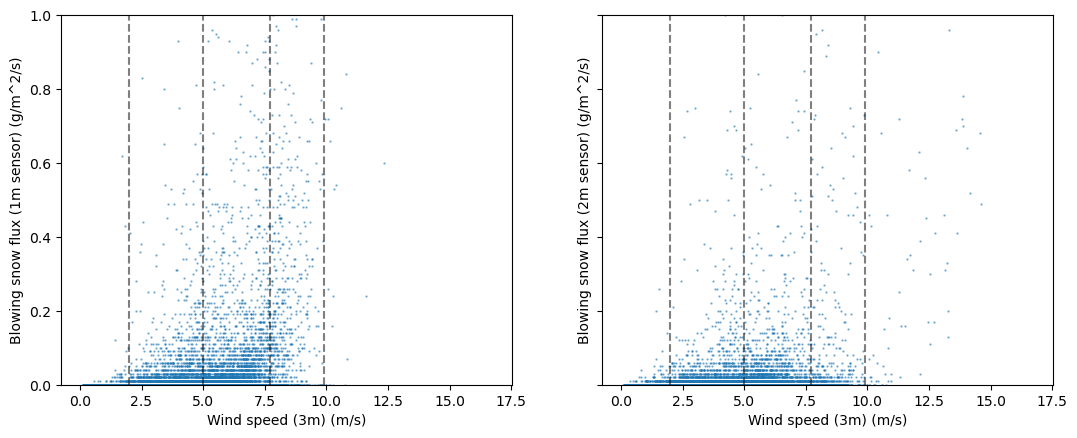

In [ ]:

fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")

plt.ylim(0,1)


Only looking at data 0-1 days after snowfall

(0.0, 1.0)

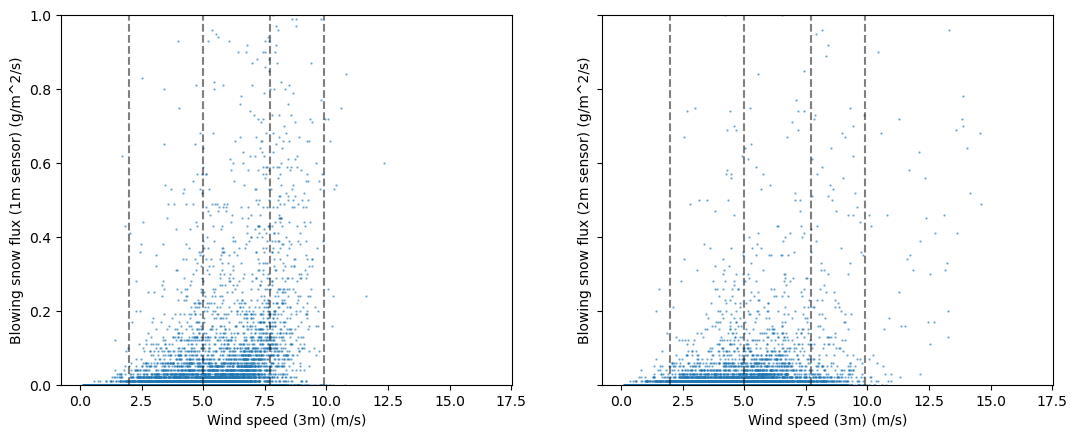

In [ ]:
src = tidy_df_5Min[
    tidy_df_5Min.time.dt.date.isin(
        precip_df[precip_df['days_since_precip'] < 2]['time'].dt.date
    )
]

fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    src.query("variable == 'spd_3m_c'").value,
    src.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    src.query("variable == 'spd_3m_c'").value,
    src.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")

plt.ylim(0,1)


With low snow surface densities:

Text(0.5, 0, 'Wind speed (3m) (m/s)')

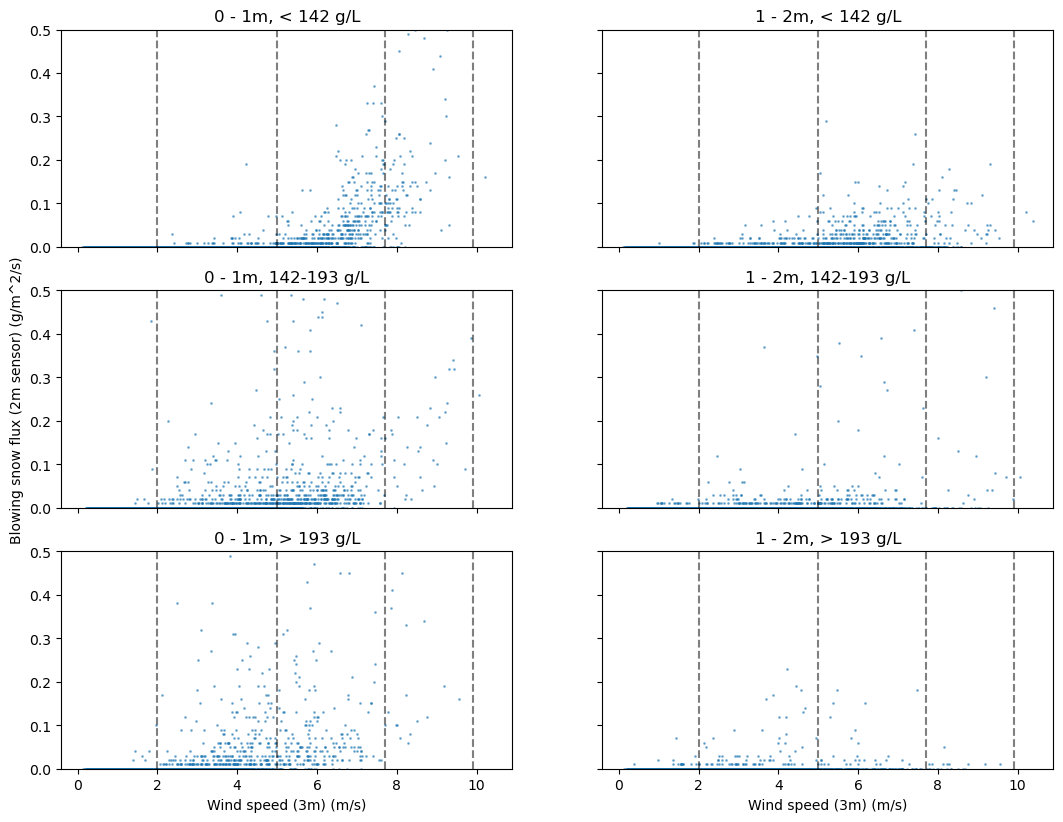

In [ ]:
src_low = tidy_df_5Min[
    tidy_df_5Min.time.dt.date.isin(
        surface_density[surface_density < 142].index.date
    )
]
src_mid = tidy_df_5Min[
    tidy_df_5Min.time.dt.date.isin(
        surface_density[(surface_density >= 142) & (surface_density <= 193)].index.date
    )
]
src_high = tidy_df_5Min[
    tidy_df_5Min.time.dt.date.isin(
        surface_density[surface_density > 193].index.date
    )
]

fig, axes = plt.subplots(3,2, figsize=(12.8, 9.6), sharey=True, sharex=True)
for ax in axes.ravel():
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)
        ax.set_ylim(0,0.5)

axes[0,0].set_title("0 - 1m, < 142 g/L")
axes[0,0].scatter(
    src_low.query("variable == 'spd_3m_c'").value,
    src_low.query("variable == 'SF_avg_1m_ue'").value,
    s=1.0,
    alpha=0.5
)
axes[0,1].set_title("1 - 2m, < 142 g/L")
axes[0,1].scatter(
    src_low.query("variable == 'spd_3m_c'").value,
    src_low.query("variable == 'SF_avg_2m_ue'").value,
    s=1.0,
    alpha=0.5
)

axes[1,0].set_title("0 - 1m, 142-193 g/L")
axes[1,0].scatter(
    src_mid.query("variable == 'spd_3m_c'").value,
    src_mid.query("variable == 'SF_avg_1m_ue'").value,
    s=1.0,
    alpha=0.5
)
axes[1,1].set_title("1 - 2m, 142-193 g/L")
axes[1,1].scatter(
    src_mid.query("variable == 'spd_3m_c'").value,
    src_mid.query("variable == 'SF_avg_2m_ue'").value,
    s=1.0,
    alpha=0.5
)

axes[2, 0].set_title("0 - 1m, > 193 g/L")
axes[2, 0].scatter(
    src_high.query("variable == 'spd_3m_c'").value,
    src_high.query("variable == 'SF_avg_1m_ue'").value,
    s=1.0,
    alpha=0.5
)
axes[2, 1].set_title("1 - 2m, > 193 g/L")
axes[2, 1].scatter(
    src_high.query("variable == 'spd_3m_c'").value,
    src_high.query("variable == 'SF_avg_2m_ue'").value,
    s=1.0,
    alpha=0.5
)

axes[1, 0].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[2, 0].set_xlabel("Wind speed (3m) (m/s)")
axes[2, 1].set_xlabel("Wind speed (3m) (m/s)")

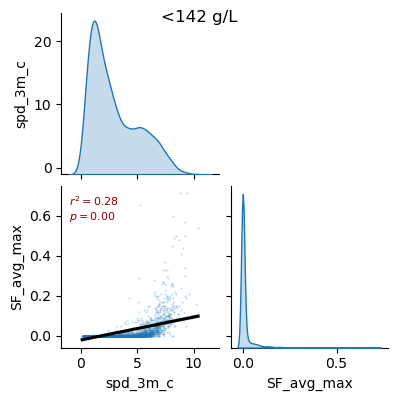

In [ ]:
def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=x, y=y)
    ax.annotate(
        # f'$r^2 = {r_value ** 2:.2f}$\n$p = {p_value:.2f}$\nEq: ${slope:.2f}x{intercept:+.2f}$',
        f'$r^2 = {r_value ** 2:.2f}$\n$p = {p_value:.2f}$',
        xy=(.05, .95), xycoords=ax.transAxes, fontsize=8,
        color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')
    
df = src_low[src_low.variable.isin(['spd_3m_c','SF_avg_1m_ue','SF_avg_2m_ue'])].pivot_table(
    values='value',
    index='time',
    columns='variable'
).reset_index(drop=True)

df['SF_avg_max'] = df[["SF_avg_1m_ue", "SF_avg_2m_ue"]].max(axis=1)
df = df[['spd_3m_c', 'SF_avg_max']]
g = sns.pairplot(df.dropna(), kind='reg', diag_kind='kde', height=2,
                 plot_kws={'line_kws': {'color': 'black'}, 'scatter_kws':{'s':0.25, 'alpha':0.25}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.suptitle("<142 g/L")
plt.show()

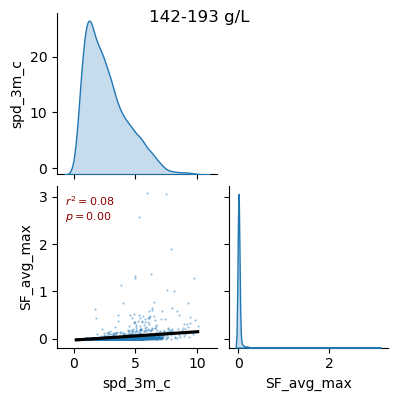

In [ ]:
df = src_mid[src_mid.variable.isin(['spd_3m_c','SF_avg_1m_ue','SF_avg_2m_ue'])].pivot_table(
    values='value',
    index='time',
    columns='variable'
).reset_index(drop=True)

df['SF_avg_max'] = df[["SF_avg_1m_ue", "SF_avg_2m_ue"]].max(axis=1)
df = df[['spd_3m_c', 'SF_avg_max']]
g = sns.pairplot(df.dropna(), kind='reg', diag_kind='kde', height=2,
                 plot_kws={'line_kws': {'color': 'black'}, 'scatter_kws':{'s':0.25, 'alpha':0.5}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.suptitle("142-193 g/L")
plt.show()

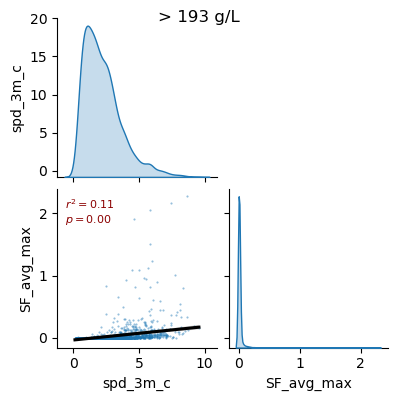

In [ ]:

df = src_high[src_high.variable.isin(['spd_3m_c','SF_avg_1m_ue','SF_avg_2m_ue'])].pivot_table(
    values='value',
    index='time',
    columns='variable'
).reset_index(drop=True)

df['SF_avg_max'] = df[["SF_avg_1m_ue", "SF_avg_2m_ue"]].max(axis=1)
df = df[['spd_3m_c', 'SF_avg_max']]
g = sns.pairplot(df.dropna(), kind='reg', diag_kind='kde', height=2,
                 plot_kws={'line_kws': {'color': 'black'}, 'scatter_kws':{'s':0.25, 'alpha':0.5}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.suptitle("> 193 g/L")
plt.show()

/tmp/ipykernel_110293/2242883318.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


(0.006346872706983886, 1)

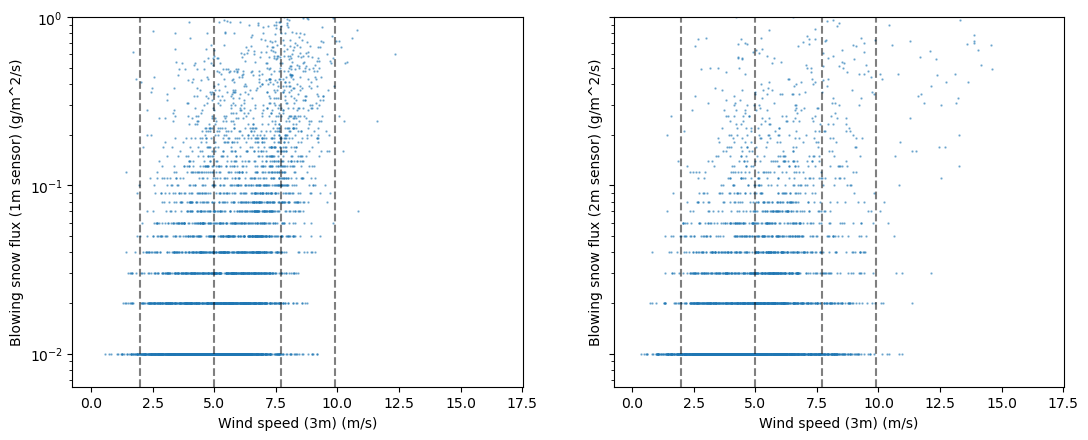

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")
axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.ylim(0,1)


### Blowing snow v shear velocity

(0.0, 1.0)

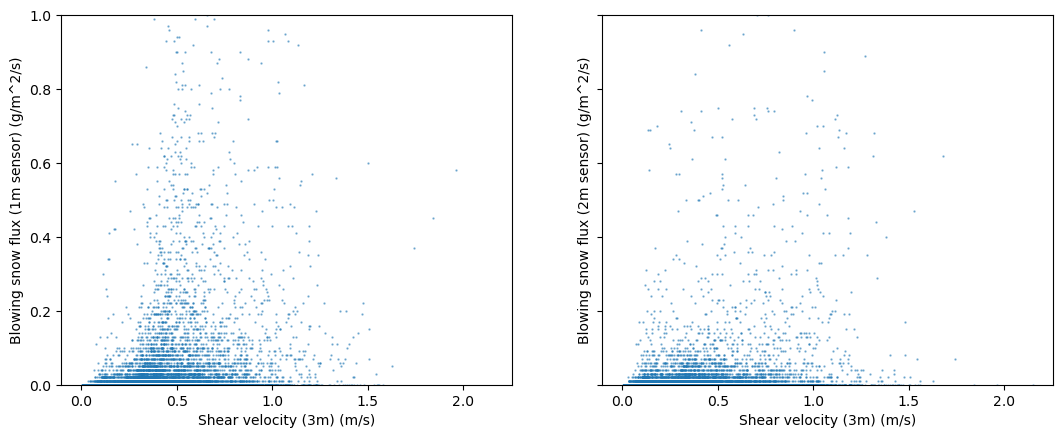

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)

axes[0].scatter(
    tidy_df_5Min.query("variable == 'u*_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_5Min.query("variable == 'u*_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Shear velocity (3m) (m/s)")
axes[1].set_xlabel("Shear velocity (3m) (m/s)")

plt.ylim(0,1)

## Blowing snow v surface snow density (snowpit data)

In [ ]:
surface_density = pd.DataFrame(
    ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-1])
).rename(columns={0:'density'})
surface_density['date'] = surface_density.index.date

In [ ]:
daily_mean_blowing_snow_flux = tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").set_index('time').groupby(pd.Grouper(freq='1D')).max()
daily_mean_blowing_snow_flux['date'] = daily_mean_blowing_snow_flux.index.date
daily_mean_blowing_snow_flux

,measurement,variable,height,tower,value,date
time,,,,,,
2022-11-29,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2022-11-29
2022-11-30,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2022-11-30
2022-12-01,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2022-12-01
2022-12-02,snow flux,SF_avg_1m_ue,1.0,ue,0.398333,2022-12-02
2022-12-03,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2022-12-03
...,...,...,...,...,...,...
2023-05-13,snow flux,SF_avg_1m_ue,1.0,ue,0.003333,2023-05-13
2023-05-14,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2023-05-14
2023-05-15,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2023-05-15


<AxesSubplot: xlabel='time'>

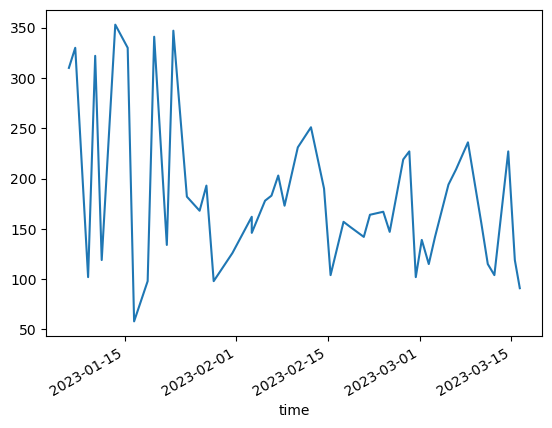

In [ ]:
surface_density['density'].plot()

<AxesSubplot: xlabel='density', ylabel='value'>

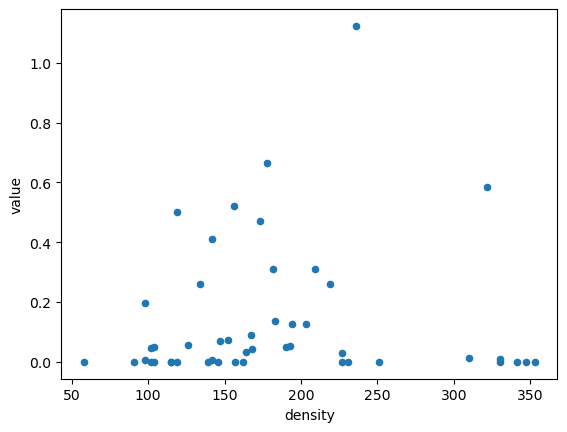

In [ ]:
daily_mean_blowing_snow_flux.merge(surface_density, on='date').plot.scatter("density", 'value')

## Blowing snow vs synoptic wind speeds

In [ ]:
blowing_snow_src = tidy_df_5Min[
    tidy_df_5Min.variable.isin([
        'SF_avg_1m_ue', 'SF_avg_2m_ue', 'w_h2o__3m_c', 'Ri_3m_c', 'RiB_3m_c', 'tke_3m_c', 'RH_3m_c', 'RH_2m_c', 'RH_20m_c', 'RH_1m_c',
        'mixingratio_2m_c', 'mixingratio_20m_c'
    ])
].pivot_table(
    index=['time'], 
    values='value', 
    columns='variable'
).reset_index()
blowing_snow_src['date'] = blowing_snow_src['time'].dt.date
blowing_snow_src

variable,time,RH_20m_c,RH_2m_c,RH_3m_c,RiB_3m_c,Ri_3m_c,SF_avg_1m_ue,SF_avg_2m_ue,mixingratio_20m_c,mixingratio_2m_c,tke_3m_c,w_h2o__3m_c,date
0,2022-11-29 17:02:30,68.949188,73.791054,68.460388,0.441074,0.152030,0.0,0.0,0.001402,0.001478,1.097155,-0.001036,2022-11-29
1,2022-11-29 17:07:30,71.711372,76.740654,70.529083,0.819425,0.144215,0.0,0.0,0.001436,0.001490,0.523634,-0.000371,2022-11-29
2,2022-11-29 17:12:30,67.166389,74.418770,68.807625,0.675544,0.109604,0.0,0.0,0.001371,0.001467,0.566816,0.000529,2022-11-29
3,2022-11-29 17:17:30,65.450745,68.706001,63.797810,0.595939,0.070564,0.0,0.0,0.001345,0.001395,1.619609,-0.001167,2022-11-29
4,2022-11-29 17:22:30,60.207161,63.175522,58.585175,0.678938,0.133814,0.0,0.0,0.001252,0.001293,1.353298,0.004871,2022-11-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47758,2023-05-17 17:37:30,37.164600,40.731033,37.633244,NaN,NaN,0.0,0.0,0.004619,0.005167,0.825950,0.031935,2023-05-17
47759,2023-05-17 17:42:30,37.658508,40.242340,37.277603,NaN,NaN,0.0,0.0,0.004699,0.005197,1.163058,0.036312,2023-05-17
47760,2023-05-17 17:47:30,38.504272,40.474533,37.586182,NaN,NaN,0.0,0.0,0.004750,0.005193,2.055442,0.028285,2023-05-17
47761,2023-05-17 17:52:30,42.095901,44.378460,41.210209,NaN,NaN,0.0,0.0,0.004953,0.005457,2.056523,0.040082,2023-05-17


In [ ]:
synoptic_winds_df['date'] = synoptic_winds_df['time'].dt.date
synoptic_winds_df = synoptic_winds_df.groupby(["date"]).mean()
synoptic_winds_df = synoptic_winds_df.reset_index()
synoptic_winds_df

/tmp/ipykernel_110293/1695601996.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  synoptic_winds_df = synoptic_winds_df.groupby(["date"]).mean()


,date,deg,wspd
0,2022-01-01,331.675690,6.728829
1,2022-01-02,167.757889,1.274737
2,2022-01-03,241.497177,0.924294
3,2022-01-04,260.759430,5.761321
4,2022-01-05,324.879517,8.110241
...,...,...,...
488,2023-05-05,262.818176,2.500699
489,2023-05-06,151.300751,1.769925
490,2023-05-07,142.668442,3.772727
491,2023-05-08,189.905029,1.407821


In [ ]:
blowing_snow_and_synoptic_winds_df = pd.merge(
    blowing_snow_src, 
    synoptic_winds_df, 
    how='left', 
    on='date'
) 

In [ ]:
(alt.Chart(
    synoptic_winds_df
).mark_bar().encode(
    alt.X("wspd:Q", title='wind speed').bin(maxbins=10),
    alt.Y("count():Q")
) + 
alt.Chart(
    synoptic_winds_df
).mark_line(color='red').transform_density(
    'wspd',
    as_ = ['wind speed', 'density']
).encode(
    alt.X("wind speed:Q"),
    alt.Y("density:Q")
) 
).resolve_scale(y='independent')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
blowing_snow_and_synoptic_winds_df['Synoptic wind speed bin'] = pd.cut(
    blowing_snow_and_synoptic_winds_df['wspd'],
    [0,1,2,3,4,5,6,7,8,9,10,np.ceil(blowing_snow_and_synoptic_winds_df['wspd'].max())]
)

blowing_snow_and_synoptic_winds_df['TKE bin'] = pd.qcut(
    blowing_snow_and_synoptic_winds_df['tke_3m_c'],
    [0,0.2,0.4,0.6,0.8,1.0]
)

blowing_snow_and_synoptic_winds_df['Synoptic wind speed bin'] = blowing_snow_and_synoptic_winds_df['Synoptic wind speed bin'].apply(lambda x: x.left + 0.5).astype('float')
blowing_snow_and_synoptic_winds_df['TKE bin'] = blowing_snow_and_synoptic_winds_df['TKE bin'].astype(str)

In [ ]:
alt.Chart(
        blowing_snow_and_synoptic_winds_df[
            blowing_snow_and_synoptic_winds_df['TKE bin'] != 'nan'
        ].query("SF_avg_1m_ue > 0").dropna()
    ).mark_boxplot().encode(
        alt.X("TKE bin:O").axis(labelAngle=30),
        alt.Y("SF_avg_1m_ue:Q").scale(type='log')
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for TKE bins'],
        width = 200
    )

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
domain = list(np.linspace(0.5, 10.5, 11))
(
    alt.Chart(
        blowing_snow_and_synoptic_winds_df.query("SF_avg_1m_ue > 0").dropna()
    ).mark_boxplot().encode(
        alt.X("Synoptic wind speed bin:O").axis(values=domain),
        alt.Y("SF_avg_1m_ue:Q").scale(type='log')
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for binned 500hPa wind speeds']
    ) | \
    alt.Chart(
        blowing_snow_and_synoptic_winds_df.query("SF_avg_1m_ue == 0").dropna()
    ).mark_bar().encode(
        alt.X("Synoptic wind speed bin:O").axis(values=domain),
        alt.Y("count():Q")
    ).properties(
        title = ['Count of zero-flux FlowCapt measurements', 'for binned 500hPa wind speeds']
    )
) & (
    alt.Chart(
        blowing_snow_and_synoptic_winds_df.query("SF_avg_2m_ue > 0").dropna()
    ).mark_boxplot().encode(
        alt.X("Synoptic wind speed bin:O").axis(values=domain),
        alt.Y("SF_avg_2m_ue:Q").scale(type='log')
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for binned 500hPa wind speeds']
    ) | \
    alt.Chart(
        blowing_snow_and_synoptic_winds_df.query("SF_avg_2m_ue == 0").dropna()
    ).mark_bar().encode(
        alt.X("Synoptic wind speed bin:O").axis(values=domain),
        alt.Y("count():Q")
    ).properties(
        title = ['Count of zero-flux FlowCapt measurements', 'for binned 500hPa wind speeds']
    )
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## LH Fluxes v synoptic wind speeds

In [ ]:
(
alt.Chart(
    blowing_snow_and_synoptic_winds_df[blowing_snow_and_synoptic_winds_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17])]
).mark_boxplot(outliers=False).encode(
    alt.X("Synoptic wind speed bin:O"),
    alt.Y("w_h2o__3m_c:Q")
).properties(
    title = ['Distribution of LH fluxes', 'for binned 500hPa wind speeds']
) |
alt.Chart(
    blowing_snow_and_synoptic_winds_df[blowing_snow_and_synoptic_winds_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17])]
).transform_calculate(
    blowing_snow = "datum.SF_avg_1m_ue > 0 | datum.SF_avg_2m_ue > 0"
).mark_boxplot(outliers=False).encode(
    alt.X("Synoptic wind speed bin:O"),
    alt.Y("w_h2o__3m_c:Q"),
    alt.Color("blowing_snow:N"),
    alt.Column("blowing_snow:N").header(labels=False, title=None)
).properties(
    title = ['Distribution of LH fluxes for binned 500hPa wind speeds,', 'during blowing snow and not']
)
).resolve_scale(y='shared').configure_title(anchor='middle')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Blowing snow vs surface snow density

In [ ]:
blowing_snow_and_surface_density_df = pd.merge(
    blowing_snow_src, 
    surface_density.reset_index(), 
    how='left', 
    on='date'
) .dropna()

In [ ]:
blowing_snow_and_surface_density_df['density_quantile'] = pd.qcut(
    blowing_snow_and_surface_density_df['density'],
    np.linspace(0,1,11)
)

blowing_snow_and_surface_density_df['density_quantile_middle'] = \
    blowing_snow_and_surface_density_df['density_quantile'].apply(
        lambda x: 0.5*(x.right+x.left)
    )

In [ ]:
blowing_snow_and_surface_density_df['SF_avg_1m_ue'].max(),blowing_snow_and_surface_density_df['SF_avg_2m_ue'].max(),

(3.069999933242798, 1.2899999618530273)

In [ ]:
blowing_snow_and_surface_density_df['SF_avg_ue'] = blowing_snow_and_surface_density_df['SF_avg_1m_ue'] + blowing_snow_and_surface_density_df['SF_avg_2m_ue']

In [ ]:
alt.Chart(
        blowing_snow_and_surface_density_df.query("SF_avg_ue > 0")
    ).mark_boxplot(outliers=True).encode(
        alt.X('density_quantile_middle:O').axis(labelAngle=30).title("Quantiles of surface snow density (kg/m^3)"),
        alt.Y("SF_avg_ue").scale(type='log').title("Blowing snow flux (g/m^2/s)")
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for binned snowpit surface density']
    )

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
(
    alt.Chart(
        blowing_snow_and_surface_density_df.query("SF_avg_1m_ue > 0")
    ).mark_boxplot(outliers=True).encode(
        alt.X('density_quantile_middle:O').axis(labelAngle=30),
        alt.Y("SF_avg_1m_ue").scale(type='log')
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for binned snowpit surface density']
    ) | alt.Chart(
        blowing_snow_and_surface_density_df.query("SF_avg_1m_ue == 0")
    ).mark_bar().encode(
        alt.X('density_quantile_middle:O').axis(labelAngle=30),
        alt.Y("count()")
    ).properties(
        title = ['Count of zero-flux FlowCapt measurements', 'for binned snowpit surface density']
    )
) & (
    alt.Chart(
        blowing_snow_and_surface_density_df.query("SF_avg_2m_ue > 0")
    ).mark_boxplot(outliers=True).encode(
        alt.X('density_quantile_middle:O').axis(labelAngle=30),
        alt.Y("SF_avg_2m_ue").scale(type='log')
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for binned snowpit surface density']
    ) | alt.Chart(
        blowing_snow_and_surface_density_df.query("SF_avg_2m_ue == 0")
    ).mark_bar().encode(
        alt.X('density_quantile_middle:O').axis(labelAngle=30),
        alt.Y("count()")
    ).properties(
        title = ['Count of zero-flux FlowCapt measurements', 'for binned snowpit surface density']
    )
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
(
alt.Chart(
    blowing_snow_and_surface_density_df[blowing_snow_and_surface_density_df.time_x.dt.hour.isin([8,9,10,11,12,13,14,15,16,17])]
).mark_boxplot(outliers=False).encode(
    alt.X("density_quantile_middle:O"),
    alt.Y("w_h2o__3m_c:Q")
).properties(
    title = ['Distribution of LH fluxes', 'for binned 500hPa wind speeds']
) |
alt.Chart(
    blowing_snow_and_surface_density_df[blowing_snow_and_surface_density_df.time_x.dt.hour.isin([8,9,10,11,12,13,14,15,16,17])]
).transform_calculate(
    blowing_snow = "datum.SF_avg_1m_ue > 0 | datum.SF_avg_2m_ue > 0"
).mark_boxplot(outliers=False).encode(
    alt.X("density_quantile_middle:O"),
    alt.Y("w_h2o__3m_c:Q"),
    alt.Color("blowing_snow:N"),
    alt.Column("blowing_snow:N").header(labels=False, title=None)
).properties(
    title = ['Distribution of LH fluxes for binned 500hPa wind speeds,', 'during blowing snow and not']
)
).resolve_scale(y='shared').configure_title(anchor='middle')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Blowing Snow vs RH

In [ ]:
blowing_snow_30min_src = tidy_df_30Min[
    tidy_df_30Min.variable.isin([
        'SF_avg_1m_ue', 'SF_avg_2m_ue', 
        'w_h2o__3m_c', 
        'Ri_3m_c', 'RiB_3m_c', 
        'tke_3m_c', 
        'RH_1m_c',  'RH_2m_c', 'RH_3m_c','RH_20m_c', 
        'mixingratio_2m_c', 'mixingratio_20m_c',
        'w_h2o__3m_c predicted (turbpy MO Holtslag de Bruin)',
        'spd_3m_c'
    ])
].pivot_table(
    index=['time'], 
    values='value', 
    columns='variable'
).reset_index()
blowing_snow_30min_src

variable,time,RH_20m_c,RH_2m_c,RH_3m_c,RiB_3m_c,Ri_3m_c,SF_avg_1m_ue,SF_avg_2m_ue,mixingratio_20m_c,mixingratio_2m_c,spd_3m_c,tke_3m_c,w_h2o__3m_c,w_h2o__3m_c predicted (turbpy MO Holtslag de Bruin)
0,2022-11-29 17:00:00,65.667576,70.618516,65.300786,0.690699,0.119395,0.0,0.0,0.001342,0.001406,3.323426,0.997178,0.001584,0.001144
1,2022-11-29 17:30:00,49.620516,55.424561,50.735089,0.798596,0.116963,0.0,0.0,0.001023,0.001072,4.556745,1.303165,0.001530,0.001436
2,2022-11-29 18:00:00,50.476727,54.980861,50.324087,1.742330,0.309685,0.0,0.0,0.001016,0.001034,3.731591,0.884484,-0.000297,0.000545
3,2022-11-29 18:30:00,61.223112,66.518649,61.213638,10.015189,2.038709,0.0,0.0,0.001085,0.001098,1.838974,0.778518,0.000404,-0.000089
4,2022-11-29 19:00:00,67.811877,76.875226,70.831669,37.897870,0.933350,0.0,0.0,0.001120,0.001138,1.354227,0.611288,-0.000359,-0.000074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7977,2023-05-17 15:30:00,30.933083,32.909925,30.443745,NaN,NaN,0.0,0.0,0.004143,0.004621,4.693956,0.822167,0.033596,NaN
7978,2023-05-17 16:00:00,33.565555,35.812260,33.170502,NaN,NaN,0.0,0.0,0.004392,0.004889,4.374811,0.691368,0.029292,NaN
7979,2023-05-17 16:30:00,32.936679,35.178612,32.588952,NaN,NaN,0.0,0.0,0.004305,0.004743,4.092707,0.767262,0.025573,NaN
7980,2023-05-17 17:00:00,33.908282,36.675371,33.913057,NaN,NaN,0.0,0.0,0.004356,0.004820,4.707404,0.824705,0.025568,NaN


In [ ]:
blowing_snow_30min_src['SF_avg_ue'] = blowing_snow_30min_src['SF_avg_1m_ue'] + blowing_snow_30min_src['SF_avg_2m_ue']
(
    alt.Chart(
        blowing_snow_30min_src.query(
            "SF_avg_ue > 0"
        )
    ).mark_circle(size=3).encode(
        alt.X("SF_avg_ue:Q").scale(type='log'),
        alt.Y("RH_2m_c:Q")
    ) | alt.Chart(
        blowing_snow_30min_src.query(
            "SF_avg_ue > 0"
        )       
    ).mark_circle(size=3).encode(
        alt.X("SF_avg_ue:Q").scale(type='log'),
        alt.Y("RH_3m_c:Q")
    )
).configure_axis(grid=False).resolve_scale(y='shared', x='shared')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
blowing_snow_30min_src['RH_2m_20m_diff_c'] = blowing_snow_30min_src['RH_2m_c'] - blowing_snow_30min_src['RH_20m_c']
blowing_snow_30min_src['mixingratio_2m_20m_diff_c'] = blowing_snow_30min_src['mixingratio_2m_c'] - blowing_snow_30min_src['mixingratio_20m_c']

blowing_snow_30min_src['w_h2o__3m_c model normalized'] = blowing_snow_30min_src['w_h2o__3m_c'] / blowing_snow_30min_src['w_h2o__3m_c predicted (turbpy MO Holtslag de Bruin)']
blowing_snow_30min_src['w_h2o__3m_c wind normalized'] = blowing_snow_30min_src['w_h2o__3m_c'] / blowing_snow_30min_src['spd_3m_c']

In [ ]:
(alt.Chart(
        blowing_snow_30min_src.query(
            "SF_avg_ue > 0"
        )
    ).mark_circle(size=5).encode(
        alt.X("SF_avg_ue:Q").scale(type='log'),
        alt.Y("w_h2o__3m_c wind normalized:Q").scale(domain = [-0.005, 0.01])
    )  | \
alt.Chart(
        blowing_snow_30min_src.query(
            "SF_avg_ue > 0"
        )
    ).mark_circle(size=5).encode(
        alt.X("SF_avg_ue:Q").scale(type='log'),
        alt.Y("w_h2o__3m_c model normalized:Q").scale(domain = [-2, 6])
    )).interactive().configure_axis(grid=False).display(renderer='svg')
    

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
alt.Chart(
        blowing_snow_30min_src.query(
            "SF_avg_ue > 0"
        )
    ).mark_circle(size=3).encode(
        alt.X("SF_avg_ue:Q").scale(type='log'),
        alt.Y("mixingratio_2m_20m_diff_c:Q")
    ) 

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
src = blowing_snow_30min_src.query(
    "SF_avg_ue > 0"
).query(
    "mixingratio_2m_20m_diff_c > 0.0004"
)
src['date'] = src.time.dt.date.astype(str)
print(src.date.value_counts())
print(src.RH_3m_c.min())
print(src.RH_3m_c.max())
print(src.time.dt.hour.value_counts())

display(
    alt.Chart(
        src
    ).mark_circle().encode(
        alt.X("SF_avg_ue:Q").scale(type='log'),
        alt.Y("mixingratio_2m_20m_diff_c:Q"),
        alt.Color("date:O").scale(scheme='rainbow'),
        tooltip = 'date'
    ).configure_axis(grid=False).display(renderer = 'svg')
)

2023-03-16    11
2023-04-15     9
2023-03-30     7
2023-04-28     6
2023-04-03     5
2023-04-08     2
2023-04-02     1
2023-04-07     1
2023-04-13     1
2023-04-27     1
Name: date, dtype: int64
26.75749746958415
65.42810567220052
12    9
11    7
13    7
14    5
15    4
10    4
16    2
17    2
18    2
9     1
20    1
Name: time, dtype: int64


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


None

In [ ]:
alt.Chart(
        blowing_snow_30min_src.query(
            "SF_avg_ue > 0"
        )
    ).mark_circle(size=5).encode(
        alt.X("SF_avg_ue:Q").scale(type='log'),
        alt.Y("mixingratio_2m_20m_diff_c:Q")
    ).configure_axis(grid=False).display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
pd.cut(
    src['SF_avg_ue'],
    np.logspace(-3, 2, 6),
    labels = 3*np.logspace(-3, 2, 6)[:-1]
)

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


113     0.003
114     0.030
115     0.030
116     0.003
117     0.003
        ...  
7696    0.030
7697    0.003
7698    0.003
7711    0.003
7783    0.003
Name: SF_avg_ue, Length: 1695, dtype: category
Categories (5, float64): [0.003 < 0.030 < 0.300 < 3.000 < 30.000]

In [ ]:
src = blowing_snow_30min_src.query("SF_avg_ue > 0")
src['SF_avg_ue']

variable,time,RH_20m_c,RH_2m_c,RH_3m_c,RiB_3m_c,Ri_3m_c,SF_avg_1m_ue,SF_avg_2m_ue,mixingratio_20m_c,mixingratio_2m_c,spd_3m_c,tke_3m_c,w_h2o__3m_c,w_h2o__3m_c predicted (turbpy MO Holtslag de Bruin),SF_avg_ue,RH_2m_20m_diff_c,mixingratio_2m_20m_diff_c,w_h2o__3m_c model normalized,w_h2o__3m_c wind normalized
113,2022-12-02 01:30:00,82.682826,87.857641,81.406985,-0.061249,0.051239,0.003333,0.006667,0.003615,0.003790,2.624866,0.187308,-0.000559,0.008153,0.010000,5.174815,0.000175,-0.068505,-0.000213
114,2022-12-02 02:00:00,91.706623,95.559747,88.692599,-0.108624,0.016328,0.020000,0.040000,0.003808,0.003937,3.264925,0.189333,-0.000709,0.007570,0.060000,3.853124,0.000130,-0.093652,-0.000217
115,2022-12-02 02:30:00,92.374502,98.157906,91.194045,-0.157553,0.053206,0.010000,0.020000,0.003841,0.004005,2.890123,0.249111,0.000148,0.006309,0.030000,5.783404,0.000164,0.023474,0.000051
116,2022-12-02 03:00:00,90.022310,96.083014,89.412421,-0.166268,0.579482,0.001667,0.005000,0.003774,0.003970,2.023708,0.361361,-0.000072,0.004616,0.006667,6.060705,0.000195,-0.015510,-0.000035
117,2022-12-02 03:30:00,75.794967,84.384018,78.440671,0.035584,4.542603,0.001667,0.001667,0.003385,0.003651,2.114323,1.778735,0.012003,0.005351,0.003333,8.589051,0.000267,2.243116,0.005677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7696,2023-05-11 19:00:00,86.424760,91.194669,84.611688,NaN,NaN,0.011667,0.018333,0.005703,0.005866,6.142916,1.057400,0.004461,NaN,0.030000,4.769909,0.000163,NaN,0.000726
7697,2023-05-11 19:30:00,82.905084,88.106369,81.694139,NaN,NaN,0.001667,0.001667,0.005603,0.005773,5.705146,0.846067,0.005608,NaN,0.003333,5.201285,0.000170,NaN,0.000983
7698,2023-05-11 20:00:00,79.954999,85.272522,79.013238,NaN,NaN,0.000000,0.001667,0.005479,0.005666,5.455414,0.823110,0.007585,NaN,0.001667,5.317523,0.000187,NaN,0.001390
7711,2023-05-12 02:30:00,72.687079,77.021217,71.324348,NaN,NaN,0.003333,0.003333,0.005190,0.005380,5.616149,1.178070,0.005185,NaN,0.006667,4.334138,0.000190,NaN,0.000923


# Split dataset into blowing snow/calm using a blowing snow sensitivity threshold

## Set the measured blowing snow threshold value here.

Values considered thus far: {0.00, 0.01, 0.025}.

In [60]:
BLOWING_SNOW_SENSITIVITY_THRESHOLD = 0.00

# Calculate total sublimation during blowing snow vs calm conditions

## Split 5 minute data into blowing snow and calm datasets

In [61]:
blowing_snow_data = tidy_df_5Min[
    tidy_df_5Min.time.isin(
        tidy_df_5Min[tidy_df_5Min.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].query(
            f"value > {BLOWING_SNOW_SENSITIVITY_THRESHOLD}"
        ).time
    )
]
calm_data = tidy_df_5Min[
    ~ tidy_df_5Min.time.isin(
        tidy_df_5Min[tidy_df_5Min.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].query(f"value > {BLOWING_SNOW_SENSITIVITY_THRESHOLD}").time
    )
]
len(blowing_snow_data.time.unique()), len(calm_data.time.unique()), len(blowing_snow_data.time.unique()), len(calm_data.time.unique())

(6292, 42380, 6292, 42380)

In [62]:
assert ( len(tidy_df_5Min) == len(blowing_snow_data) + len(calm_data) )
print(len(tidy_df_5Min)),
print(len(blowing_snow_data) + len(calm_data))

24920064
24920064


In [63]:
mm_sublimated_df = pd.DataFrame(
    calm_data.query("measurement == 'w_h2o_'").groupby(
        ["height", "tower"]
    ).value.sum()*60*5*0.001
).rename(
    columns={'value': 'calm'}
).merge(
    pd.DataFrame(
        blowing_snow_data.query("measurement == 'w_h2o_'").groupby(
            ["height", "tower"]
        ).value.sum()*60*5*0.001)
    .rename(
        columns={'value': 'blowing snow'}
    ),
    on = ['height', 'tower']
)
mm_sublimated_df['total mm sublimation'] = mm_sublimated_df['blowing snow'] + mm_sublimated_df['calm'] 
mm_sublimated_df['percent blowing snow'] = round(
    100*mm_sublimated_df['blowing snow']/mm_sublimated_df['total mm sublimation'],
    1
)
mm_sublimated_df

calm  blowing snow  total mm sublimation  \
height tower                                                  
1.0    d      18.039416      7.128234             25.167650   
       ue     21.119973      8.811372             29.931345   
       uw     17.770179      5.447482             23.217661   
2.0    c      24.079552     11.947788             36.027340   
3.0    c      26.101467     14.294569             40.396036   
       d      27.445995     13.579560             41.025556   
       ue     26.292150     14.399240             40.691390   
       uw     27.806907     13.316439             41.123345   
5.0    c      27.868267     15.862642             43.730909   
10.0   c      29.976744     19.587093             49.563838   
       d      26.712226     16.927324             43.639550   
       ue     26.336009     17.101697             43.437705   
       uw     30.080152     16.547612             46.627764   
15.0   c      21.184706     13.825701             35.010407   
20.0   c      25.437036     18.181968             43.619004   

              percent blowing snow  
height tower                        
1.0    d                      28.3  
       ue                     29.4  
       uw                     23.5  
2.0    c                      33.2  
3.0    c                      35.4  
       d                      33.1  
       ue                     35.4  
       uw                     32.4  
5.0    c                      36.3  
10.0   c                      39.5  
       d                      38.8  
       ue                     39.4  
       uw                     35.5  
15.0   c                      39.5  
20.0   c                      41.7

# Plot

## Total seasonal sublimation during blowing snow and calm conditions

In [64]:
src = mm_sublimated_df.drop([
    (3, 'ue'),
    (10, 'c'),
    (1, 'uw')
])
mean_percent_blowing_snow = round(src['percent blowing snow'].mean(),1)
src = src.melt(ignore_index=False, value_vars=['calm', 'blowing snow']).reset_index()

alt.Chart(
    src
).transform_filter(alt.FieldOneOfPredicate('height', [3, 10])).mark_bar().encode(
    x="tower:N",
    # xOffset = 'variable:N',
    y=alt.Y("value:Q").title("Seasonal sublimation (mm)"),
    color="variable:N",
    column="height:N"
).configure_legend(orient='top').properties(
    title=[
        f'Threshold: {BLOWING_SNOW_SENSITIVITY_THRESHOLD}',
        f'Sublimation during blowing snow: {mean_percent_blowing_snow}%'
    ]
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Cumulative distribution of sublimation measurements over the range of (non-zero) FlowCapt measurement quantiles

In [65]:
cum_blowing_sublimation_df = blowing_snow_data[
    blowing_snow_data['variable'].isin(['w_h2o__3m_c', 'SF_avg_1m_ue'])
].pivot_table(
    index=['time'], 
    values='value', 
    columns='variable'
).reset_index()

cum_blowing_sublimation_df['sublimation (mm)'] = cum_blowing_sublimation_df['w_h2o__3m_c']*60*5*.001

# add jitter so that pd.qcut can work even though there are a ton of the same values at the smallest values that the flowcapt can measure (See the logscale scatter plots above)
def jitter(a_series, noise_reduction=100000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

cum_blowing_sublimation_df['FlowCapt measurement quantile'] = pd.qcut(
    cum_blowing_sublimation_df['SF_avg_1m_ue'] +  jitter(cum_blowing_sublimation_df['SF_avg_1m_ue']),
    np.linspace(0,100, 101)*0.01,
    labels = np.linspace(1,100, 100)*0.01
)

cum_blowing_sublimation_quantiles_df = pd.DataFrame(
    cum_blowing_sublimation_df.groupby("FlowCapt measurement quantile")['sublimation (mm)'].sum()
)
cum_blowing_sublimation_quantiles_df['Cumulative sublimation (mm)'] = cum_blowing_sublimation_quantiles_df['sublimation (mm)'].cumsum()
cum_blowing_sublimation_quantiles_df

alt.Chart(cum_blowing_sublimation_quantiles_df.reset_index()).mark_point().encode(
    x = alt.X('FlowCapt measurement quantile:Q'),
    y = 'Cumulative sublimation (mm)'
).properties(width=200, height=200)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Distribution of LH fluxes for blowing snow flux, mixing ratio, and RH quantiles

In [66]:
cum_blowing_sublimation_df = blowing_snow_data[
    blowing_snow_data['variable'].isin(['w_h2o__3m_c', 'SF_avg_1m_ue', 'SF_avg_2m_ue', 'mixingratio_3m_c', 'RH_3m_c'])
].pivot_table(
    index=['time'], 
    values='value', 
    columns='variable'
).reset_index()
cum_blowing_sublimation_df['SF_avg_max'] = cum_blowing_sublimation_df[['SF_avg_1m_ue', 'SF_avg_2m_ue']].max(axis=1)

cum_blowing_sublimation_df['FlowCapt measurement quantile'] = pd.qcut(
    cum_blowing_sublimation_df['SF_avg_max'] +  jitter(cum_blowing_sublimation_df['SF_avg_max']),
    np.linspace(0,1,11),
    labels = np.linspace(0,1,11)[:-1]
)

cum_blowing_sublimation_df['Q measurement quantile'] = pd.qcut(
    cum_blowing_sublimation_df['mixingratio_3m_c'],
    np.linspace(0,1,11),
    labels = np.linspace(0,1,11)[:-1]
)

cum_blowing_sublimation_df['RH measurement quantile'] = pd.qcut(
    cum_blowing_sublimation_df['RH_3m_c'],
    np.linspace(0,1,11),
    labels = np.linspace(0,1,11)[:-1]
)

In [67]:
alt.Chart(cum_blowing_sublimation_df).mark_boxplot(outliers=False).encode(
    alt.X("FlowCapt measurement quantile:Q"),
    alt.Y("w_h2o__3m_c:Q")
) | alt.Chart(cum_blowing_sublimation_df).mark_boxplot(outliers=False).encode(
    alt.X("Q measurement quantile:Q"),
    alt.Y("w_h2o__3m_c:Q")
) | alt.Chart(cum_blowing_sublimation_df).mark_boxplot(outliers=False).encode(
    alt.X("RH measurement quantile:Q"),
    alt.Y("w_h2o__3m_c:Q")
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Occurence of (non)blowing snow sublimation throughout the season

Only data prior to April 9 (when melt began) and after 11/30 (so we don't have 1 day of data for a month)

In [68]:
src_blow = blowing_snow_data[blowing_snow_data['time'] < '2023-04-09']
src_calm = calm_data[calm_data['time'] < '2023-04-09']

src_blow = src_blow.assign(month = src_blow['time'].dt.month).query("variable == 'w_h2o__3m_c'")
src_calm = src_calm.assign(month = src_calm['time'].dt.month).query("variable == 'w_h2o__3m_c'")

src_blow = src_blow.assign(type = 'blowing snow')
src_calm = src_calm.assign(type = 'calm')
src = pd.concat([
    src_blow,
    src_calm
])
src['time_water_year_adj'] = src['time'] + dt.timedelta(days = 92)
src['week of water year'] = src['time_water_year_adj'].dt.week

/tmp/ipykernel_2195/222469941.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  src['week of water year'] = src['time_water_year_adj'].dt.week


In [69]:
alt.Chart(src[src['time'].dt.month != 11]).mark_boxplot(outliers=False).encode(
    alt.X("month(time):N").sort([11,12,1,2,3,4]),
    alt.Y("value:Q").title(["Latent heat flux (g/m^2/s),", "(5 minute averages)"]),
    alt.XOffset("type:N"),
    alt.Color("type:N")
).properties(
    title=["Eddy covariance measurements of latent heat flux", "during blowing snow and calm conditions"]
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [70]:
alt.Chart(src).mark_boxplot(outliers=False).encode(
    alt.X("week of water year:O"),
    alt.Y("value:Q").title(["Latent heat flux (g/m^2/s),", "(5 minute averages)"]),\
    alt.XOffset("type:N"),
    alt.Color("type:N")
).properties(
    title=["Eddy covariance measurements of latent heat flux", "during blowing snow and calm conditions"],
    width=800
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Correlations of Blowing Snow Flux and Precipitation

In [71]:
def average_snowflux_values(m1, m2):
    if m1 > 0 and m2 > 0:
        return (m1 + m2) / 2
    elif m1 > 0 and m2 == 0:
        return m1
    elif m2 > 0 and m1 == 0:
        return m2
    elif m1 == 0 and m2 == 0:
        return 0
    elif np.isnan(m1):
        return m2
    elif np.isnan(m2):
        return m1
    else:
        print("WTF HAPPENED?")
        return np.nan

combo_df = blowing_snow_data[blowing_snow_data.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue', 'w_h2o__3m_c'])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
).reset_index().merge(precip_5min_df, on='time')
combo_df['SF_avg'] = combo_df.apply(
    lambda row: average_snowflux_values(row['SF_avg_1m_ue'], row['SF_avg_2m_ue']),
    axis=1
)
combo_df.head()

,time,SF_avg_1m_ue,SF_avg_2m_ue,w_h2o__3m_c,precip_rate,SF_avg
0,2022-12-02 01:52:30,0.01,0.02,-0.003112,3.0212,0.015
1,2022-12-02 01:57:30,0.01,0.02,0.000102,3.6092,0.015
2,2022-12-02 02:02:30,0.01,0.01,0.000221,1.9678,0.010
3,2022-12-02 02:12:30,0.03,0.06,-0.000963,5.2908,0.045
4,2022-12-02 02:17:30,0.04,0.08,-0.002835,4.2056,0.060


In [72]:
(alt.Chart(combo_df).mark_circle(size=5, opacity=0.25).encode(
    alt.X('precip_rate').title("Disdrometer precip rate (mm/hr)"),
    alt.Y('SF_avg').scale(type='log'),
).properties(height = 100) & alt.Chart(
    combo_df[['precip_rate']]
).transform_density(
    'precip_rate',
    as_=['precip_rate', 'density'],
    groupby=['type']
).mark_line().encode(
    alt.X('precip_rate').title("Disdrometer precip rate (mm/hr)"),
    y='density:Q'
).properties(height = 200)).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [73]:
combo_df['precip'] = combo_df['precip_rate'] > 0

In [74]:
combo_df_no_precip = combo_df[ ~ combo_df.precip]

combo_df_all_precip = combo_df.query("precip")
combo_df_all_precip['precip rate quantile'] = pd.qcut(
    combo_df_all_precip['precip_rate'], 
    8
)
# combo_df_all_precip['precip rate quantile'] = combo_df_all_precip['precip rate quantile'].astype(str)
combo_df_all_precip['precip rate quantile'] = combo_df_all_precip['precip rate quantile'].apply(lambda duo: str(round(duo.left, 3)) + "-" + str(round(duo.right, 3)))

/tmp/ipykernel_2195/757767484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_df_all_precip['precip rate quantile'] = pd.qcut(
/tmp/ipykernel_2195/757767484.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_df_all_precip['precip rate quantile'] = combo_df_all_precip['precip rate quantile'].apply(lambda duo: str(round(duo.left, 3)) + "-" + str(round(duo.right, 3)))


In [75]:
(
    alt.Chart(combo_df).mark_boxplot(outliers=False).encode(
        alt.X('precip:N'),
        alt.Y('SF_avg:Q'),   
    ).properties(
        title = ['FlowCapt measurements', '(not) during snowfall'],
        width=100
    ) 
        | 
    alt.Chart(combo_df_all_precip).mark_boxplot(outliers=False).encode(
        alt.X('precip rate quantile:O').axis(labelAngle=20),
        alt.Y('SF_avg'),   
    ).properties(
        title = ['FlowCapt measurements during', 'different precip rates'],
        width=300, 
        height=200
    )
).resolve_scale(y='shared').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Cumulative sublimation per precipitation rate during snowfall

In [76]:
combo_df_all_precip

combo_df_all_precip['precip rate quantile'] = pd.qcut(
    combo_df_all_precip['precip_rate'],
    np.linspace(0,100, 101)*0.01,
    labels = np.linspace(1,100, 100)*0.01
)

combo_df_all_precip['sublimation (mm)'] = combo_df_all_precip['w_h2o__3m_c']*60*5*.001

cumulative_sublimation_per_precip_rate_quantile_df = pd.DataFrame(
    combo_df_all_precip.groupby("precip rate quantile")['sublimation (mm)'].sum()
).reset_index()

cumulative_sublimation_per_precip_rate_quantile_df['Cumulative sublimation (mm)'] = cumulative_sublimation_per_precip_rate_quantile_df['sublimation (mm)'].cumsum()
cumulative_sublimation_per_precip_rate_quantile_df

/tmp/ipykernel_2195/3784268783.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_df_all_precip['precip rate quantile'] = pd.qcut(
/tmp/ipykernel_2195/3784268783.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_df_all_precip['sublimation (mm)'] = combo_df_all_precip['w_h2o__3m_c']*60*5*.001


,precip rate quantile,sublimation (mm),Cumulative sublimation (mm)
0,0.01,0.179110,0.179110
1,0.02,0.086792,0.265902
2,0.03,0.084738,0.350641
3,0.04,0.087817,0.438458
4,0.05,0.082306,0.520764
...,...,...,...
95,0.96,0.059503,5.282558
96,0.97,0.081155,5.363713
97,0.98,0.087928,5.451640
98,0.99,0.106632,5.558272


In [77]:
alt.Chart(cumulative_sublimation_per_precip_rate_quantile_df).mark_point().encode(
    alt.X("precip rate quantile:Q"),
    alt.Y("Cumulative sublimation (mm)")
).properties(width=200, height=200).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [78]:
scipy.stats.spearmanr(
        blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'Rsw_in_9m_d'").value.values,
        blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value.values,
        nan_policy='omit'
    )

SignificanceResult(statistic=0.3969475692527725, pvalue=5.216630828512778e-114)

In [79]:
def calm_v_blowing_plot(blowing_snow_data, calm_data):
    fig, axes = plt.subplots(2,3, figsize=(12, 6.4), sharey=True, sharex="col")
    axes[0,0].set_ylabel("Blowing snow data\n\nLatent heat flux (g/m^2/s)")
    x_vals_00 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'Rsw_in_9m_d'").value
    y_vals_00 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_00,
        y_vals_00,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[0,0].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[0,0].scatter(
        x_vals_00,
        y_vals_00,
        s=0.2,
        alpha=0.2
    )
    axes[1,0].set_ylabel("Calm data\n\nLatent heat flux (g/m^2/s)")
    axes[1,0].set_xlabel("Incoming shortwave radiation (W/m^2)")
    x_vals_10 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'Rsw_in_9m_d'").value
    y_vals_10 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_10,
        y_vals_10,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[1,0].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[1,0].scatter(
        x_vals_10,
        y_vals_10,
        s=0.2,
        alpha=0.2
    )
    x_vals_01 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'spd_3m_c'").value
    y_vals_01 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_01,
        y_vals_01,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[0,1].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[0,1].scatter(
        x_vals_01,
        y_vals_01,
        s=0.2,
        alpha=0.2
    )
    axes[1,1].set_xlabel("Wind speed (m/s)")
    x_vals_11 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'spd_3m_c'").value
    y_vals_11 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_11,
        y_vals_11,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[1,1].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[1,1].scatter(
        x_vals_11,
        y_vals_11,
        s=0.2,
        alpha=0.2
    )
    x_vals_02 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'q_gradient_3m_c'").value
    y_vals_02 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_02,
        y_vals_02,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[0,2].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[0,2].scatter(
        x_vals_02,
        y_vals_02,
        s=0.2,
        alpha=0.2
    )
    axes[1,2].set_xlabel("Mixing ratio gradient (m^-1)")
    x_vals_12 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'q_gradient_3m_c'").value
    y_vals_12 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_12,
        y_vals_12,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[1,2].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[1,2].scatter(
        x_vals_12,
        y_vals_12,
        s=0.2,
        alpha=0.2
    )
    plt.show()

## Plot scatterplots of explanatory variables for LH flux

### With wind Rsw, Wind speed, and q gradient

#### All data

SignificanceResult(statistic=0.3969475692527725, pvalue=5.216630828512778e-114)
SignificanceResult(statistic=0.4128269760480787, pvalue=0.0)
SignificanceResult(statistic=0.31420958681529454, pvalue=6.171165367579614e-70)
SignificanceResult(statistic=0.5418584725817754, pvalue=0.0)
SignificanceResult(statistic=-0.5509434964081996, pvalue=2.8370030289574556e-238)
SignificanceResult(statistic=-0.619961493637507, pvalue=0.0)


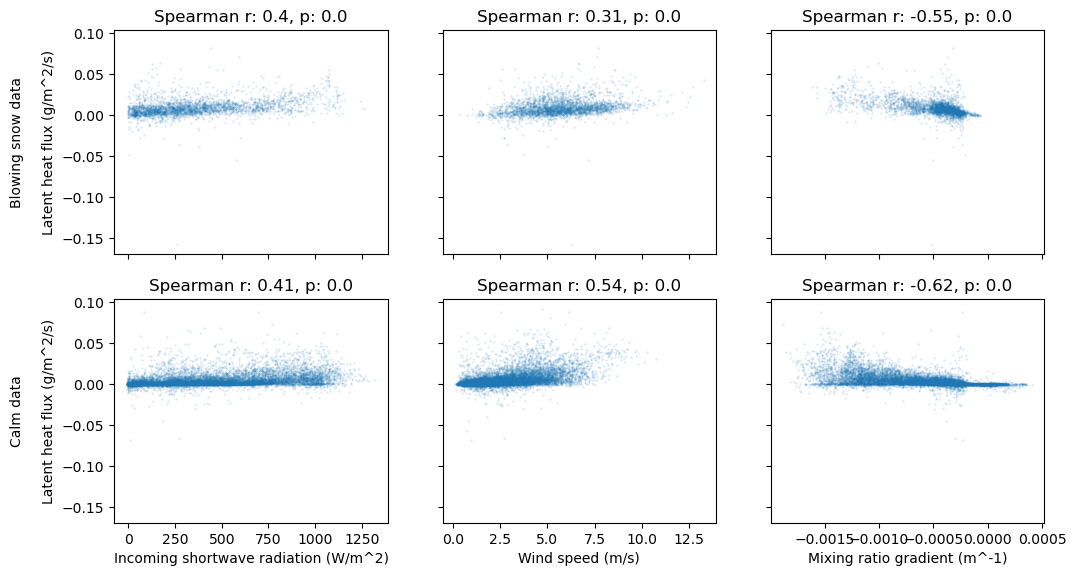

In [80]:
calm_v_blowing_plot(blowing_snow_data, calm_data)

# Create datasets for different stability regimes

In [81]:
blowing_snow_data_stable = blowing_snow_data[blowing_snow_data['time'].isin(
    blowing_snow_data.query("variable == 'Ri_3m_c'").query("value > 0.25").time.unique()
)]

calm_data_stable = calm_data[calm_data['time'].isin(
    calm_data.query("variable == 'Ri_3m_c'").query("value > 0.25").time.unique()
)]

blowing_snow_data_unstable = blowing_snow_data[blowing_snow_data['time'].isin(
    blowing_snow_data.query("variable == 'Ri_3m_c'").query("value < -0.25").time.unique()
)]

calm_data_unstable = calm_data[calm_data['time'].isin(
    calm_data.query("variable == 'Ri_3m_c'").query("value < -0.25").time.unique()
)]

blowing_snow_data_neutral = blowing_snow_data[blowing_snow_data['time'].isin(
    blowing_snow_data.query("variable == 'Ri_3m_c'").query("value >= -0.25").query("value <= 0.25").time.unique()
)]

calm_data_neutral = calm_data[calm_data['time'].isin(
    calm_data.query("variable == 'Ri_3m_c'").query("value >= -0.25").query("value <= 0.25").time.unique()
)]


In [82]:
tidy_5min_by_stability_and_blowing_df = pd.concat([
    blowing_snow_data_stable.assign(stability = 'stable').assign(type = 'blowing snow'),
    blowing_snow_data_neutral.assign(stability = 'neutral').assign(type = 'blowing snow'),
    blowing_snow_data_unstable.assign(stability = 'unstable').assign(type = 'blowing snow'),
    calm_data_stable.assign(stability = 'stable').assign(type = 'clear'),
    calm_data_neutral.assign(stability = 'neutral').assign(type = 'clear'),
    calm_data_unstable.assign(stability = 'unstable').assign(type = 'clear')
])

# Plot 

## Measured vs predicted LH fluxes/sublimation

### Create a dataset with stability and blowing snow/non-blowing snow indicated using the 30 minute data, which has the modeled values

In [83]:
blowing_snow_data_30min = tidy_df_30Min[
    tidy_df_30Min.time.isin(
        tidy_df_30Min[tidy_df_30Min.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].query(
            f"value > {BLOWING_SNOW_SENSITIVITY_THRESHOLD}"
        ).time
    )
]
calm_data_30min = tidy_df_30Min[
    ~ tidy_df_30Min.time.isin(
        tidy_df_30Min[tidy_df_30Min.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].query(f"value > {BLOWING_SNOW_SENSITIVITY_THRESHOLD}").time
    )
]
blowing_snow_data_stable_30min = blowing_snow_data_30min[blowing_snow_data_30min['time'].isin(
    blowing_snow_data_30min.query("variable == 'Ri_3m_c'").query("value > 0.25").time.unique()
)]
calm_data_stable_30min = calm_data_30min[calm_data_30min['time'].isin(
    calm_data_30min.query("variable == 'Ri_3m_c'").query("value > 0.25").time.unique()
)]
blowing_snow_data_unstable_30min = blowing_snow_data_30min[blowing_snow_data_30min['time'].isin(
    blowing_snow_data_30min.query("variable == 'Ri_3m_c'").query("value < -0.25").time.unique()
)]
calm_data_unstable_30min = calm_data_30min[calm_data_30min['time'].isin(
    calm_data_30min.query("variable == 'Ri_3m_c'").query("value < -0.25").time.unique()
)]
blowing_snow_data_neutral_30min = blowing_snow_data_30min[blowing_snow_data_30min['time'].isin(
    blowing_snow_data_30min.query("variable == 'Ri_3m_c'").query("value >= -0.25").query("value <= 0.25").time.unique()
)]
calm_data_neutral_30min = calm_data_30min[calm_data_30min['time'].isin(
    calm_data_30min.query("variable == 'Ri_3m_c'").query("value >= -0.25").query("value <= 0.25").time.unique()
)]

tidy_30min_by_stability_and_blowing_df = pd.concat([
    blowing_snow_data_stable_30min.assign(stability = 'stable').assign(type = 'blowing snow'),
    blowing_snow_data_neutral_30min.assign(stability = 'neutral').assign(type = 'blowing snow'),
    blowing_snow_data_unstable_30min.assign(stability = 'unstable').assign(type = 'blowing snow'),
    calm_data_stable_30min.assign(stability = 'stable').assign(type = 'clear'),
    calm_data_neutral_30min.assign(stability = 'neutral').assign(type = 'clear'),
    calm_data_unstable_30min.assign(stability = 'unstable').assign(type = 'clear')
])

In [84]:
src = tidy_30min_by_stability_and_blowing_df[tidy_30min_by_stability_and_blowing_df.variable.isin(
    ['w_h2o__3m_c predicted (turbpy webb noahmp)', 'w_h2o__3m_c', 'q_gradient_3m_c', 'u_w_rot__3m_c',
     'w_tc__3m_c predicted (turbpy webb noahmp)', 'w_tc__3m_c',
     ]
)].pivot_table(
    values = 'value',
    index = ['time', 'type', 'stability'],
    columns='variable'
).reset_index()
src['model bias'] = src['w_h2o__3m_c predicted (turbpy webb noahmp)'] - src['w_h2o__3m_c']
src

KeyError: 'w_h2o__3m_c predicted (turbpy webb noahmp)'

In [ ]:
src = src[np.abs(src['w_h2o__3m_c']) < 0.1]
src = src[np.abs(src['w_h2o__3m_c predicted (turbpy webb noahmp)']) < 0.1]
domain = [-0.02, 0.06]
alt.Chart(src).mark_circle(size=5, opacity=0.25).encode(
    alt.X("w_h2o__3m_c:Q").scale(domain = domain, clamp=True).title("Measured"),
    alt.Y("w_h2o__3m_c predicted (turbpy webb noahmp):Q").scale(domain = domain, clamp=True).title("Predicted"),
).properties(width = 200, height = 200).facet("type:N").display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
# src = src[np.abs(src['w_tc__3m_c']) < 0.1]
# src = src[np.abs(src['w_tc__3m_c predicted (turbpy webb noahmp)']) < 0.1]
domain = [-.1,.1]
alt.Chart(src).mark_circle(size=5, opacity=0.25).encode(
    alt.X("w_tc__3m_c:Q").scale(domain = domain, clamp=True).title("Measured"),
    alt.Y("w_tc__3m_c predicted (turbpy webb noahmp):Q").scale(domain = domain, clamp=True).title("Predicted"),
).properties(width = 200, height = 200).facet("type:N").display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Pairplots of explanatory variables for model bias

In [ ]:
def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=x, y=y)
    ax.annotate(
        # f'$r^2 = {r_value ** 2:.2f}$\n$p = {p_value:.2f}$\nEq: ${slope:.2f}x{intercept:+.2f}$',
        f'$r^2 = {r_value ** 2:.2f}$\n$p = {p_value:.2f}$',
        xy=(.05, .95), xycoords=ax.transAxes, fontsize=8,
        color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')

In [ ]:
src = src.rename(columns = {'w_h2o__3m_c predicted (turbpy webb noahmp)': 'w_h2o__3m_c predicted'})

variable,time,type,stability,q_gradient_3m_c,u_w_rot__3m_c,w_h2o__3m_c,w_h2o__3m_c predicted,model bias
0,2022-11-29 17:00:00,clear,neutral,-0.000076,0.006267,0.001584,1.110662e-03,-0.000474
1,2022-11-29 17:30:00,clear,neutral,-0.000070,0.029073,0.001530,1.407813e-03,-0.000122
2,2022-11-29 18:00:00,clear,stable,-0.000044,0.006618,-0.000297,4.830032e-04,0.000780
3,2022-11-29 18:30:00,clear,stable,0.000042,0.002089,0.000404,-7.178188e-17,-0.000404
4,2022-11-29 19:00:00,clear,stable,0.000094,0.002107,-0.000359,-1.132640e-16,0.000359
...,...,...,...,...,...,...,...,...
7614,2023-05-11 14:00:00,blowing snow,neutral,-0.000366,0.090906,0.018011,2.243677e-02,0.004426
7615,2023-05-11 14:30:00,blowing snow,neutral,-0.000342,0.368057,-0.003718,1.550800e-02,0.019226
7616,2023-05-11 15:00:00,blowing snow,neutral,-0.000322,0.152328,0.012435,1.983485e-02,0.007400
7617,2023-05-11 15:30:00,blowing snow,neutral,-0.000325,0.153925,0.015038,1.556734e-02,0.000529


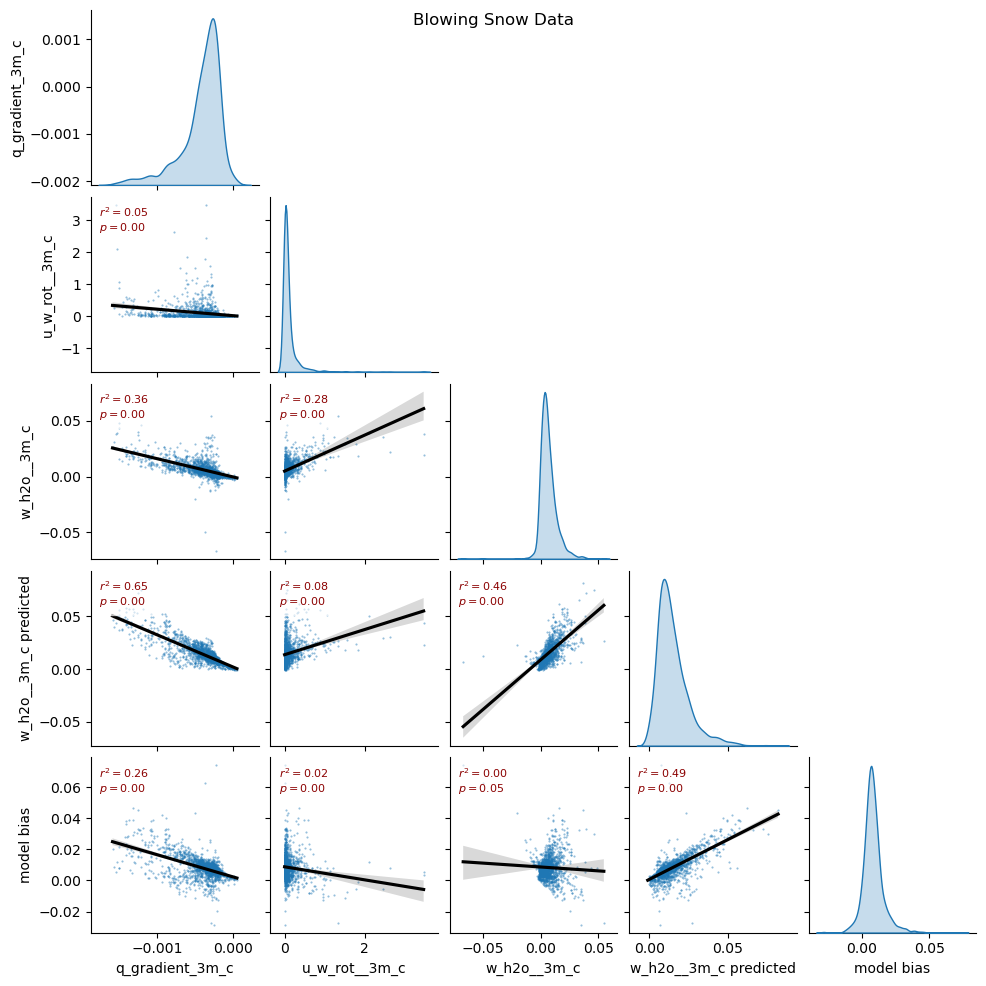

In [ ]:
g = sns.pairplot(src.query("type == 'blowing snow'").dropna(), kind='reg', diag_kind='kde', height=2,
                 plot_kws={'line_kws': {'color': 'black'}, 'scatter_kws':{'s':0.25, 'alpha':0.5}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.suptitle("Blowing Snow Data")
plt.show()

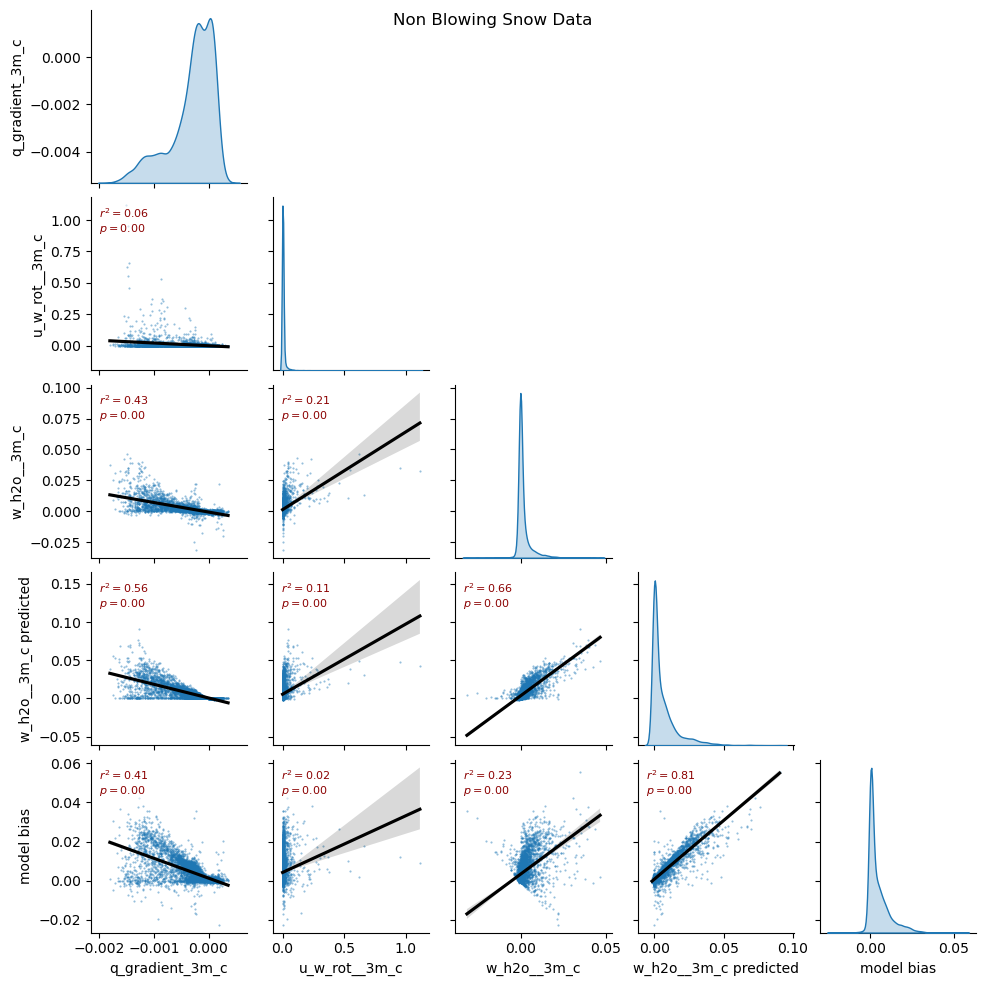

In [ ]:
g = sns.pairplot(src.query("type == 'clear'").dropna(), kind='reg', diag_kind='kde', height=2,
                 plot_kws={'line_kws': {'color': 'black'}, 'scatter_kws':{'s':0.25, 'alpha':0.5}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.suptitle("Non Blowing Snow Data")
plt.show()

## Pairplots of explanatory variables for LH flux

In [ ]:
vars = ['q_gradient_3m_c', 'spd_3m_c', 'Rnet_9m_d', 'Rsw_in_9m_d', 'w_h2o__3m_c', 'type']
src = tidy_5min_by_stability_and_blowing_df[tidy_5min_by_stability_and_blowing_df.variable.isin(vars)].pivot_table(
    values = 'value',
    index = ['time', 'type'],
    columns='variable'
).reset_index()
src = src[vars]
src = src.query("type == 'clear'")

g = sns.pairplot(src.dropna(), kind='reg', diag_kind='kde', height=2, 
                 plot_kws={'line_kws': {'color': 'black'}, 'scatter_kws':{'s':0.25, 'alpha':0.5}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.suptitle("Non Blowing Snow Data")
plt.show()

In [ ]:
vars = ['q_gradient_3m_c', 'spd_3m_c', 'Rnet_9m_d', 'temp_gradient_3m_c', 'w_h2o__3m_c']
src = blowing_snow_data[blowing_snow_data.variable.isin(vars)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()
src = src[vars]

g = sns.pairplot(src.dropna(), kind='reg', diag_kind='kde', height=2,
                 plot_kws={'line_kws': {'color': 'black'}, 'scatter_kws':{'s':0.25, 'alpha':0.5}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.suptitle("Blowing Snow Data")
plt.show()

## Wind speed distributions

In [ ]:
src = tidy_5min_by_stability_and_blowing_df[
    tidy_5min_by_stability_and_blowing_df.measurement == "wind speed"
].query("tower == 'c'")
src = src[src.height.isin([3,5,20])]
src = src.query("height == 3")

dist_chart = alt.Chart(src).mark_area(opacity=0.25).transform_density(
    'value',
    as_ = ['Wind speed (m/s)', 'KDE'],
    groupby = ["height", 'type']
).encode(
    alt.X("Wind speed (m/s):Q"),
    alt.Y("KDE:Q"),
    alt.Color("type:N"),
    # alt.Facet("height:O", columns=1)
).properties(height = 100)
dist_chart

In [ ]:
src = tidy_df_5Min[tidy_df_5Min.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue', 'spd_3m_c'])]
src = src.pivot_table(
    index=['time'], 
    values='value', 
    columns='variable'
).reset_index()
src['SF_avg_ue'] = src['SF_avg_1m_ue'] + src['SF_avg_2m_ue']
src = src.query("SF_avg_ue > 0")
scatter_chart = alt.Chart(src).mark_circle(size = 10).encode(
    alt.X("spd_3m_c:Q").title("Wind speed (m/s)"),
    alt.Y("SF_avg_ue:Q").scale(type='log').title("Blowing snow flux (g/m^2/s)")
)
scatter_chart

In [ ]:
(dist_chart & scatter_chart).resolve_scale(x='shared').configure_legend(orient='top')

In [ ]:
src = tidy_5min_by_stability_and_blowing_df[
    tidy_5min_by_stability_and_blowing_df.measurement == "wind speed"
].query("tower == 'c'")
src = src[src.height.isin([3,5,20])]
src

alt.Chart(src).mark_area(opacity=0.25).transform_density(
    'value',
    as_ = ['Wind speed (m/s)', 'KDE'],
    groupby = ['height', 'type', 'stability']
).encode(
    alt.X("Wind speed (m/s):Q"),
    alt.Y("KDE:Q"),
    alt.Color("type:N"),
    alt.Row("height:O"),
    alt.Column("stability:N")
).properties(height = 100)

## LH Flux distributions for different stability regimes

In [ ]:
# src = tidy_5min_by_stability_and_blowing_df[
#         tidy_5min_by_stability_and_blowing_df.time.dt.hour.isin([8,9,19,11,12,13,14,15,16,17])
#     ].query("variable == 'w_h2o__3m_c'")
src = tidy_5min_by_stability_and_blowing_df.query("variable == 'w_h2o__3m_c'")

(   
    alt.Chart(
        src
    ).transform_density(
        'value',
        as_=["w_h2o__3m_c", "density"],
        groupby=['stability']
    ).mark_line().encode(
        alt.X("w_h2o__3m_c:Q").scale(domain=[-0.01,0.025], clamp=True),
        alt.Y("density:Q"),
        alt.Color("stability:N")
    ).properties(title=['Distribution of LH flux measurements,', 'by stability regime'])
    | 
    alt.Chart(
        src
    ).transform_density(
        'value',
        as_=["w_h2o__3m_c", "density"],
        groupby=['stability', 'type']
    ).mark_line().encode(
        alt.X("w_h2o__3m_c:Q").scale(domain=[-0.01,0.025], clamp=True),
        alt.Y("density:Q"),
        alt.Color("stability:N"),
        alt.StrokeDash("type:N")
    ).properties(title=['Distribution of LH flux measurements,', 'by stability regime and during/not during blowing snow'])
).resolve_scale(color='independent', strokeDash='independent').configure_legend(orient='top')

In [ ]:
n_blowing_neutral = len(src.query("type == 'blowing snow'").query("stability == 'neutral'"))
n_blowing_stable = len(src.query("type == 'blowing snow'").query("stability == 'stable'"))
n_blowing_unstable = len(src.query("type == 'blowing snow'").query("stability == 'unstable'"))
n_clear_neutral = len(src.query("type == 'clear'").query("stability == 'neutral'"))
n_clear_stable = len(src.query("type == 'clear'").query("stability == 'stable'"))
n_clear_unstable = len(src.query("type == 'clear'").query("stability == 'unstable'"))

alt.Chart(
    src.drop(
        src.query("type == 'blowing snow'").query("stability == 'unstable'").index
    )
).transform_density(
    'value',
    as_=["w_h2o__3m_c", "density"],
    groupby=['stability', 'type']
).mark_line().encode(
    alt.X("w_h2o__3m_c:Q").scale(domain=[-0.01,0.03], clamp=True),
    alt.Y("density:Q").axis(title='KDE', values=[]),
    alt.Color("stability:N"),
    alt.Row("type:N")
).properties(
    height=75,
    title=[
        'Distribution of LH flux measurements by stability regime.', 
        f"Blowing snow, neutral (n = {n_blowing_neutral}), stable (n = {n_blowing_stable}), unstable (n = {n_blowing_unstable})",
        f"Clear, neutral (n = {n_clear_neutral}), stable (n = {n_clear_stable}), unstable (n = {n_clear_unstable})"
    ]
).resolve_scale(y='independent').configure_legend(orient='top')

In [ ]:

alt.Chart(
    src.query("value <= 0.04").query("value >= -0.04")
).mark_bar().encode(
    alt.X("value:Q").bin(step = 0.0025).title("w_h2o__3m_c"),
    alt.Y('count():Q'),
    alt.Column("type:N"),
    alt.Row("stability:N")
).properties(
    height=75
).resolve_scale(y='independent')

In [ ]:
print(tidy_5min_by_stability_and_blowing_df.query("variable == 'w_h2o__3m_c'").query("type == 'clear'").query("stability == 'stable'").value.mean())
print(tidy_5min_by_stability_and_blowing_df.query("variable == 'w_h2o__3m_c'").query("type == 'clear'").query("stability == 'neutral'").value.mean())
print(tidy_5min_by_stability_and_blowing_df.query("variable == 'w_h2o__3m_c'").query("type == 'clear'").query("stability == 'unstable'").value.mean())

In [ ]:
tidy_5min_by_stability_and_blowing_df.stability.value_counts() / len(tidy_5min_by_stability_and_blowing_df)

In [ ]:
src = tidy_5min_by_stability_and_blowing_df.query("variable == 'Ri_3m_c'")
src['month'] = src['time'].dt.month
src = src[
    src['value'] < 2
][
    src['value'] > -2
]
alt.Chart(src).mark_bar().encode(
    alt.X("value:Q").bin(step = 0.05).axis(values=np.linspace(-2,2,17)).title("Ri (3m)"),
    alt.Y("count()"),
    alt.Color("stability:N"),
).properties(height = 150)

## Pair plots for turbulent fluxes at multiple heights

In [ ]:
corr_src = tidy_5min_by_stability_and_blowing_df[tidy_5min_by_stability_and_blowing_df.variable.isin(
    [
        'u_w_rot__3m_c', 'tke_3m_c', 'w_w__3m_c', 'w_tc__3m_c', 'w_h2o__3m_c',
        'u_w_rot__10m_c', 'tke_10m_c', 'w_w__10m_c', 'w_tc__10m_c', 'w_h2o__10m_c',
    ]
)].pivot_table(
    index=['time', 'stability', 'type'],
    values='value', 
    columns='variable'
).reset_index().set_index('time').groupby([pd.Grouper(freq='60Min'), 'stability', 'type']).mean().reset_index()
corr_src

In [ ]:
def triple_plot(src, x, y, lims):
    base = alt.Chart(src).mark_circle(
        size=5
    ).transform_filter(
        alt.datum.type == 'clear'
    ).properties(width=200, height = 200)

    top_density_base = alt.Chart(src).mark_line(
    ).transform_filter(
        alt.datum.type == 'clear'
    ).properties(width=200, height = 50)

    right_density_base = alt.Chart(src).mark_line(
    ).transform_filter(
        alt.datum.type == 'clear'
    ).properties(width=50, height = 200)

    scale = alt.Scale()
    # scale = alt.Scale(domain=[-1,1], clamp=True)

    return (
        (
            top_density_base.transform_density(
                x,
                as_ = [x, "density"],
                groupby=['stability']
            ).encode(
                alt.X(x).scale(domain=lims, clamp=True).axis(None).title(None), 
                alt.Y("density:Q").axis(None).title(None)
            ).facet(column = alt.Column("stability:N", title=None))
            &
            (
                base.encode(
                    alt.X(x).scale(domain=lims, clamp=True),
                    alt.Y(y).scale(domain=lims, clamp=True),
                ).facet(column = alt.Column(
                    "stability:N", header=None, title=None
                    )
                )
                |
                right_density_base.transform_density(
                    y,
                    as_ = [y, "density"],
                    groupby=['stability']
                ).encode(
                    alt.Y(y).scale(domain=lims, clamp=True).axis(None).title(None), 
                    alt.X("density:Q", sort='-y').axis(None).title(None),
                    alt.Color("stability:N")
                )
            )
        )
    )

plot_1_title = 'neutral: ' + r2_string(
                    corr_src.query("stability == 'neutral'")[["w_h2o__3m_c", "w_h2o__10m_c"]].dropna()["w_h2o__3m_c"],
                    corr_src.query("stability == 'neutral'")[["w_h2o__3m_c", "w_h2o__10m_c"]].dropna()["w_h2o__10m_c"]
                ) + "    stable: " + r2_string(
                    corr_src.query("stability == 'stable'")[["w_h2o__3m_c", "w_h2o__10m_c"]].dropna()["w_h2o__3m_c"],
                    corr_src.query("stability == 'stable'")[["w_h2o__3m_c", "w_h2o__10m_c"]].dropna()["w_h2o__10m_c"]
                ) + "    unstable: " + r2_string(
                    corr_src.query("stability == 'unstable'")[["w_h2o__3m_c", "w_h2o__10m_c"]].dropna()["w_h2o__3m_c"],
                    corr_src.query("stability == 'unstable'")[["w_h2o__3m_c", "w_h2o__10m_c"]].dropna()["w_h2o__10m_c"]
                )

plot_2_title = 'neutral: ' + r2_string(
                    corr_src.query("stability == 'neutral'")[["w_tc__3m_c", "w_tc__10m_c"]].dropna()["w_tc__3m_c"],
                    corr_src.query("stability == 'neutral'")[["w_tc__3m_c", "w_tc__10m_c"]].dropna()["w_tc__10m_c"]
                ) + "    stable: " + r2_string(
                    corr_src.query("stability == 'stable'")[["w_tc__3m_c", "w_tc__10m_c"]].dropna()["w_tc__3m_c"],
                    corr_src.query("stability == 'stable'")[["w_tc__3m_c", "w_tc__10m_c"]].dropna()["w_tc__10m_c"]
                ) + "    unstable: " + r2_string(
                    corr_src.query("stability == 'unstable'")[["w_tc__3m_c", "w_tc__10m_c"]].dropna()["w_tc__3m_c"],
                    corr_src.query("stability == 'unstable'")[["w_tc__3m_c", "w_tc__10m_c"]].dropna()["w_tc__10m_c"]
                )

plot_3_title = 'neutral: ' + r2_string(
                    corr_src.query("stability == 'neutral'")[["u_w_rot__3m_c", "u_w_rot__10m_c"]].dropna()["u_w_rot__3m_c"],
                    corr_src.query("stability == 'neutral'")[["u_w_rot__3m_c", "u_w_rot__10m_c"]].dropna()["u_w_rot__10m_c"]
                ) + "    stable: " + r2_string(
                    corr_src.query("stability == 'stable'")[["u_w_rot__3m_c", "u_w_rot__10m_c"]].dropna()["u_w_rot__3m_c"],
                    corr_src.query("stability == 'stable'")[["u_w_rot__3m_c", "u_w_rot__10m_c"]].dropna()["u_w_rot__10m_c"]
                ) + "    unstable: " + r2_string(
                    corr_src.query("stability == 'unstable'")[["u_w_rot__3m_c", "u_w_rot__10m_c"]].dropna()["u_w_rot__3m_c"],
                    corr_src.query("stability == 'unstable'")[["u_w_rot__3m_c", "u_w_rot__10m_c"]].dropna()["u_w_rot__10m_c"]
                )

triple_plot(corr_src, "w_h2o__3m_c", "w_h2o__10m_c", lims=[-0.05, 0.05]).properties(title = plot_1_title) &\
triple_plot(corr_src, "w_tc__3m_c", "w_tc__10m_c", lims=[-0.05, 0.05]).properties(title = plot_2_title) &\
triple_plot(corr_src, "u_w_rot__3m_c", "u_w_rot__10m_c", lims=[0, 0.05]).properties(title = plot_3_title)

In [ ]:
sns.set_theme(style='white')

df = corr_src.query("stability == 'unstable'")[["w_h2o__3m_c", "w_h2o__10m_c"]].dropna()

def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=x, y=y)
    ax.annotate(f'$r^2 = {r_value ** 2:.2f}$\n$p = {p_value:.2f}$\nEq: ${slope:.2f}x{intercept:+.2f}$',
                xy=(.05, .95), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')



g = sns.pairplot(df, kind='reg', diag_kind='kde', height=2, size=3,
                 plot_kws={'line_kws': {'color': 'black'}, 'scatter_kws':{'s':1, 'alpha':0.1}})
g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.show()

In [ ]:

base = alt.Chart(corr_src).mark_circle(
    size=5
).transform_filter(alt.datum.type == 'blowing snow').properties(width=200, height = 200)

alt.Chart(corr_src).transform_density(
        "w_h2o__3m_c",
        as_ = ["w_h2o__3m_c", "density"],
        groupby=['type', 'stability']
    ).mark_line().encode(
        alt.X("w_h2o__3m_c"), 
        alt.Y("density:Q")
    ).facet(
        row = alt.Row("type:N"),
        column = alt.Column("stability:N"),
    )

(
    base.encode(
        alt.X("w_h2o__3m_c").scale(domain=[-0.01, 0.01], clamp=True),
        alt.Y("w_h2o__10m_c").scale(domain=[-0.01, 0.01], clamp=True),
    ).facet(
        row = alt.Row("type:N"),
        column = alt.Column("stability:N"),
    )
    &
    base.encode(
        alt.X("w_tc__3m_c").scale(domain=[-0.01, 0.01], clamp=True),
        alt.Y("w_tc__10m_c").scale(domain=[-0.01, 0.01], clamp=True),
    ).facet(
        row = alt.Row("type:N"),
        column = alt.Column("stability:N"),
    )
    &
    base.encode(
        alt.X("u_w_rot__3m_c").scale(domain=[0, 0.5], clamp=True),
        alt.Y("u_w_rot__10m_c").scale(domain=[0, 0.5], clamp=True),
    ).facet(
        row = alt.Row("type:N"),
        column = alt.Column("stability:N"),
    )
).configure_axis(grid=False)

In [ ]:
src = tidy_5min_by_stability_and_blowing_df[
        tidy_5min_by_stability_and_blowing_df.time.dt.hour.isin([8,9,19,11,12,13,14,15,16,17])
    ].query("variable == 'w_h2o_div_20m_c'")

alt.Chart(
        src
    ).transform_density(
        'value',
        as_=["w_h2o_div_20m_c", "density"],
        groupby=['stability', 'type']
    ).mark_line().encode(
        alt.X("w_h2o_div_20m_c:Q").scale(
            domain=[-0.002,0.002], 
            clamp=True
        ),
        alt.Y("density:Q"),
        alt.Color("stability:N"),
        alt.Row("type:N")
    ).properties(
        height=75,
        title=[
            'Distribution of LH flux divergence measurements,', 
            'by stability regime and during/not during blowing snow']
    ).configure_legend(orient='top')

In [ ]:
alt.Chart(
    src
).mark_boxplot(outliers=False).encode(
    alt.X("value:Q"),
    alt.Y("type:N"),
).properties(title=['Distribution of LH flux measurements,', 'during/not during blowing snow']) &\
alt.Chart(
    src
).mark_boxplot(outliers=False).encode(
    alt.X("value:Q"),
    alt.Y("stability:N"),
).properties(title=['Distribution of LH flux measurements,', 'by stability regime'])

In [ ]:
src = tidy_5min_by_stability_and_blowing_df.query("variable == 'w_h2o_div_20m_c'")

src = src[
      src['time'] > "2023-01-31"
  ][
    src['time'] < "2023-02-08"
  ]
src = src.set_index("time").resample("60Min").mean().reset_index()
alt.Chart(
    src
).mark_line().encode(
  alt.X("time:T"),
alt.Y("value:Q")
).properties(width=800)

In [ ]:
calm_v_blowing_plot(blowing_snow_data_stable, calm_data_stable)
calm_v_blowing_plot(blowing_snow_data_unstable, calm_data_unstable)
calm_v_blowing_plot(blowing_snow_data_neutral, calm_data_neutral)

### With Rsw, separately for +/- q gradient

#### Blowing snow data only

In [ ]:
src = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_pos_qgrad = src[src['time'].isin(blowing_snow_data.query("variable == 'q_gradient_3m_c'").query("value > 0").time)]
src_neg_qgrad = src[src['time'].isin(blowing_snow_data.query("variable == 'q_gradient_3m_c'").query("value <= 0").time)]

fig, axes = plt.subplots(2,2, figsize=(8,8), sharey=True)
axes[0,0].scatter(
    src_neg_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,0].set_title(f"q gradient < 0 (n = {len(src_neg_qgrad)})")
axes[0,0].set_ylabel("Latent heat flux (g/m^2/s)")
axes[0,0].set_xlabel("Incoming shortwave radiation (W/m^2)")
axes[0,0].set_xlim(0,1200)
axes[0,1].scatter(
    src_pos_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,1].set_title(f"q gradient > 0 (n = {len(src_pos_qgrad)})")
axes[0,1].set_xlabel("Incoming shortwave radiation (W/m^2)")
axes[0,1].set_xlim(0,1200)
axes[1,0].scatter(
    src_neg_qgrad.query("variable == 'spd_3m_c'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,0].set_title(f"q gradient < 0 (n = {len(src_neg_qgrad)})")
axes[1,0].set_ylabel("Latent heat flux (g/m^2/s)")
axes[1,0].set_xlabel("Wind speed (m/s)")
axes[1,0].set_xlim(0,10)
axes[1,1].scatter(
    src_pos_qgrad.query("variable == 'spd_3m_c'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,1].set_title(f"q gradient > 0 (n = {len(src_pos_qgrad)})")
axes[1,1].set_xlabel("Wind speed (m/s)")

axes[1,1].set_xlim(0,10)
plt.suptitle("Blowing Snow Data")
plt.tight_layout()

#### Calm data only

In [ ]:
src = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_pos_qgrad = src[src['time'].isin(calm_data.query("variable == 'q_gradient_3m_c'").query("value > 0").time)]
src_neg_qgrad = src[src['time'].isin(calm_data.query("variable == 'q_gradient_3m_c'").query("value <= 0").time)]


fig, axes = plt.subplots(2,2, figsize=(8,8), sharey=True)
axes[0,0].scatter(
    src_neg_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,0].set_title(f"q gradient < 0 (n = {len(src_neg_qgrad)})")
axes[0,0].set_ylabel("Latent heat flux (g/m^2/s)")
axes[0,0].set_xlabel("Incoming shortwave radiation (W/m^2)")
axes[0,0].set_xlim(0,1200)
axes[0,1].scatter(
    src_pos_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,1].set_title(f"q gradient > 0 (n = {len(src_pos_qgrad)})")
axes[0,1].set_xlabel("Incoming shortwave radiation (W/m^2)")
axes[0,1].set_xlim(0,1200)
axes[1,0].scatter(
    src_neg_qgrad.query("variable == 'spd_3m_c'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,0].set_title(f"q gradient < 0 (n = {len(src_neg_qgrad)})")
axes[1,0].set_ylabel("Latent heat flux (g/m^2/s)")
axes[1,0].set_xlabel("Wind speed (m/s)")
axes[1,0].set_xlim(0,10)
axes[1,1].scatter(
    src_pos_qgrad.query("variable == 'spd_3m_c'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,1].set_title(f"q gradient > 0 (n = {len(src_pos_qgrad)})")
axes[1,1].set_xlabel("Wind speed (m/s)")

axes[1,1].set_xlim(0,10)
plt.suptitle("Calm Data")
plt.tight_layout()

## Distribution of Latent Heat fluxes for different q gradients

In [ ]:
src_blowing = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_blowing = src_blowing[src_blowing.variable.isin(['q_gradient_3m_c', 'w_h2o__3m_c'])]
src_blowing = src_blowing.pivot_table(index=['time'], values='value', columns='variable').reset_index()
src_blowing = src_blowing.assign(type = "blowing")

src_calm = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_calm = src_calm[src_calm.variable.isin(['q_gradient_3m_c', 'w_h2o__3m_c'])]
src_calm = src_calm.pivot_table(index=['time'], values='value', columns='variable').reset_index()
src_calm = src_calm.assign(type = "calm")

src = pd.concat([src_calm, src_blowing])
# src['q_gradient_bins'] = pd.cut(src['q_gradient_3m_c'], bins=10).astype(str)
src['q_gradient_bins'] = pd.cut(
    src['q_gradient_3m_c'], 
    bins=np.linspace(-0.002, 0.001, 13),    
    labels = (np.linspace(-0.002, 0.001, 13) + .00025)[:-1].round(5)
)

src = src.dropna()

# nudge them slightly left and slightly right so they can overlap and it still looks good
src['q_gradient_bins'] = src.apply(
    lambda row: row['q_gradient_bins'] - 3.125e-05 
        if row['type'] == 'calm' else row['q_gradient_bins'] + 3.125e-05,
    axis = 1
)

boxplot = alt.Chart(src).mark_boxplot(outliers=False, opacity=0.75).encode(
    alt.X("q_gradient_bins:Q"),
    alt.Y("w_h2o__3m_c:Q"),
    alt.XOffset("type:N"),
    alt.Color("type:N")
)
boxplot

## Distributions of q gradients

In [ ]:
distplot = alt.Chart(
    src[['q_gradient_3m_c', 'type']].reset_index(drop=True)
).transform_density(
    'q_gradient_3m_c',
    as_=['q_gradient_3m_c', 'density'],
    groupby=['type']
).mark_line().encode(
    x="q_gradient_3m_c",
    y='density:Q',
    color='type:N'
)
distplot

In [ ]:
(distplot.properties(height=100) & boxplot).resolve_scale(x='shared').display(renderer='svg')

## Cumulative distribution of sublimation measurements over the range of q_gradient quantiles, ignoring counter gradient fluxes (q_gradient > 0).

In [ ]:
cum_src_blowing = src.query("q_gradient_3m_c <= 0").query("type == 'blowing'")
cum_src_calm = src.query("q_gradient_3m_c <= 0").query("type == 'calm'")

cum_src_blowing['sublimation (mm)'] = cum_src_blowing['w_h2o__3m_c']*60*5*.001
cum_src_calm['sublimation (mm)'] = cum_src_calm['w_h2o__3m_c']*60*5*.001

cum_src_blowing['q gradient quantile'] = pd.qcut(
    cum_src_blowing['q_gradient_3m_c'],
    np.linspace(0,100, 101)*0.01,
    labels = np.linspace(1,100, 100)*0.01
)
cum_src_calm['q gradient quantile'] = pd.qcut(
    cum_src_calm['q_gradient_3m_c'],
    np.linspace(0,100, 101)*0.01,
    labels = np.linspace(1,100, 100)*0.01
)

cum_grad_quantiles_blowing = pd.DataFrame(
    cum_src_blowing.groupby("q gradient quantile")['sublimation (mm)'].sum()
)
cum_grad_quantiles_calm = pd.DataFrame(
    cum_src_calm.groupby("q gradient quantile")['sublimation (mm)'].sum()
)

cum_grad_quantiles_blowing['Cumulative sublimation (mm)'] = cum_grad_quantiles_blowing['sublimation (mm)'].cumsum()
cum_grad_quantiles_calm['Cumulative sublimation (mm)'] = cum_grad_quantiles_calm['sublimation (mm)'].cumsum()

cum_grad_quantiles_blowing = cum_grad_quantiles_blowing.reset_index().assign(type='blowing')
cum_grad_quantiles_calm = cum_grad_quantiles_calm.reset_index().assign(type='calm')

cum_grad_quantiles_blowing["% of Cumulative sublimation (mm)"] = cum_grad_quantiles_blowing["Cumulative sublimation (mm)"] / cum_grad_quantiles_blowing["Cumulative sublimation (mm)"].max()
cum_grad_quantiles_calm["% of Cumulative sublimation (mm)"] = cum_grad_quantiles_calm["Cumulative sublimation (mm)"] / cum_grad_quantiles_calm["Cumulative sublimation (mm)"].max()

cum_grad_quantiles = pd.concat([cum_grad_quantiles_blowing, cum_grad_quantiles_calm])

alt.Chart(cum_grad_quantiles).mark_point().encode(
    alt.X('q gradient quantile:Q'),
    alt.Y('Cumulative sublimation (mm):Q'),
    color = 'type:N'
).properties(width=200, height=200) | alt.Chart(cum_grad_quantiles).mark_point().encode(
    alt.X('q gradient quantile:Q'),
    alt.Y('% of Cumulative sublimation (mm):Q'),
    color = 'type:N'
).properties(width=200, height=200)

# OLD: Daily data, exploring "syntopically active/weak" and "cloudy/clear sky" classifications

In [ ]:
daily_sos_and_synoptic_df["synoptically active"] = daily_sos_and_synoptic_df["wspd"] > 5
daily_sos_and_synoptic_df["clear sky"] = daily_sos_and_synoptic_df['percent_opaque'] < 35

In [ ]:
daily_sos_and_synoptic_df['season'] = ''
daily_sos_and_synoptic_df.loc[pd.to_datetime(daily_sos_and_synoptic_df['time']) <= '2023-02-28', 'season'] = 'winter'
daily_sos_and_synoptic_df.loc[pd.to_datetime(daily_sos_and_synoptic_df['time']) > '2023-02-28', 'season'] = 'spring'

In [ ]:
daily_sos_and_synoptic_df['Daily sublimation (mm)'] = daily_sos_and_synoptic_df['Cumulative sublimation (mm)'].diff().fillna(0)
daily_sos_and_synoptic_df['blowing snow'] = daily_sos_and_synoptic_df['snow flux'] > 0

In [ ]:
daily_sos_and_synoptic_df['month'] = daily_sos_and_synoptic_df.time.apply(lambda date: date.month)
alt.Chart(
    daily_sos_and_synoptic_df
).mark_boxplot().encode(
    alt.X("month:O", sort = [11,12,1,2,3,4,5]),
    alt.Y("Daily sublimation (mm):Q"),
    alt.Color("clear sky:N"),
    alt.XOffset("clear sky:N"),
    alt.Row("blowing snow:N")
).properties(height = 100)

In [ ]:
print("Spring season, SW radiation as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, with clear sky: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, with clear sky: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, with clear sky: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, with clear sky: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, without clear sky: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, without clear sky: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, without clear sky: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, without clear sky: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))

(alt.Chart(daily_sos_and_synoptic_df).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("clear sky"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N") & \
alt.Chart(
    daily_sos_and_synoptic_df
    # daily_sos_and_synoptic_df[daily_sos_and_synoptic_df["snow flux"] > 0]
).mark_circle().encode(
    alt.X("snow flux:Q").scale(clamp=True, domain=[0, 0.05]),
    # alt.X("snow flux:Q").scale(type='log'),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("clear sky"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")).properties(title = 'Sublimation predictors during Winter and Spring with clear/Not-clear sky')

In [ ]:
alt.Chart(daily_sos_and_synoptic_df).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("clear sky"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")

In [ ]:
print("Spring season, SW radiation as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, not synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, not synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, not synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, not synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))

(alt.Chart(daily_sos_and_synoptic_df).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("synoptically active"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N") & \
alt.Chart(
    daily_sos_and_synoptic_df
    # daily_sos_and_synoptic_df[daily_sos_and_synoptic_df["snow flux"] > 0]
).mark_circle().encode(
    alt.X("snow flux:Q").scale(clamp=True, domain=[0, 0.05]),
    # alt.X("snow flux:Q").scale(type='log'),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("synoptically active"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")).properties(title = 'Sublimation predictors during Winter and Spring with synoptically active/not')

In [ ]:
src = daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky'] & ~daily_sos_and_synoptic_df["synoptically active"]]

print("Spring season, SW radiation as predictor: " + r2_string(
    src.query("season == 'spring'")["shortwave radiation incoming"],
    src.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor: " + r2_string(
    src.query("season == 'winter'")["shortwave radiation incoming"],
    src.query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor: " + r2_string(
    src.query("season == 'spring'")["snow flux"],
    src.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor: " + r2_string(
    src.query("season == 'winter'")["snow flux"],
    src.query("season == 'winter'")["Daily sublimation (mm)"]
))

(alt.Chart(src).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N") & \
alt.Chart(
    src
    # daily_sos_and_synoptic_df[daily_sos_and_synoptic_df["snow flux"] > 0]
).mark_circle().encode(
    alt.X("snow flux:Q").scale(clamp=True, domain=[0, 0.05]),
    # alt.X("snow flux:Q").scale(type='log'),
    alt.Y("Daily sublimation (mm)"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")).properties(title = 'Sublimation predictors during Winter and Spring during clear sky, synoptically weak days')

## High rate data

In [ ]:
(
    alt.Chart(tidy_df_30Min).transform_filter(
        alt.FieldOneOfPredicate('variable', ['w_h2o__3m_c'])
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q"),
        alt.Color("variable:N")
    )  
+ 
    alt.Chart(tidy_df_30Min).transform_filter(
        alt.FieldOneOfPredicate('variable', ['Rsw_in_9m_d'])
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q"),
        alt.Color("variable:N")
    ) 
).resolve_scale(y='independent').properties(width=1000)

In [ ]:
wide_df = tidy_df_30Min[
    tidy_df_30Min["variable"].isin(['w_h2o__3m_c', 'Rsw_in_9m_d', 'SF_avg_1m_ue', 'SF_avg_2m_ue'])
][['time', 'variable', 'value']].pivot_table(values = 'value', index='time', columns=['variable']).reset_index()

wide_df['SF_avg_ue'] =  wide_df[['SF_avg_1m_ue',	'SF_avg_2m_ue']].mean(axis=1)

wide_df

In [ ]:
clear_sky_syn_weak_days = daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky'] & ~daily_sos_and_synoptic_df["synoptically active"]]['time']

In [ ]:
wide_df_clear_sky_syn_weak = wide_df[wide_df['time'].dt.date.isin(clear_sky_syn_weak_days)]
wide_df_clear_sky_syn_weak = wide_df_clear_sky_syn_weak[wide_df_clear_sky_syn_weak["Rsw_in_9m_d"] > 0]

In [ ]:
wide_df_clear_sky_syn_weak
alt.Chart(wide_df_clear_sky_syn_weak).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("Rsw_in_9m_d:Q"),
    alt.Y("w_h2o__3m_c:Q")
)

In [ ]:
alt.Chart(wide_df_clear_sky_syn_weak).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("Rsw_in_9m_d:Q"),
    alt.Y("w_h2o__3m_c:Q")
) | alt.Chart(wide_df_clear_sky_syn_weak).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("SF_avg_ue:Q"),
    alt.Y("w_h2o__3m_c:Q")
) | alt.Chart(wide_df_clear_sky_syn_weak).transform_filter(
    alt.datum.SF_avg_ue > 0
).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("SF_avg_ue:Q").scale(type='log'),
    alt.Y("w_h2o__3m_c:Q")
)

# Composite vertical Q profiles

In [ ]:
src = tidy_5min_by_stability_and_blowing_df[
    (tidy_5min_by_stability_and_blowing_df.time > "2022-12-08") & 
    (tidy_5min_by_stability_and_blowing_df.time < "2022-12-10")
]
alt.Chart(
    src[src.variable.isin(['Ri_3m_c'])] 
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(domain=[-2,2], clamp=True),
    alt.Color("stability:N")
).properties(width=800)

### Composites for different stability regimes and blowing snow vs calm conditions

In [ ]:
src = tidy_5min_by_stability_and_blowing_df[
    tidy_5min_by_stability_and_blowing_df.time.dt.hour.isin([
        8,9,10,11,12,13,14,15,16,17
    ])
]

src = src[
    src.measurement.isin(['mixing ratio', 'RH', 'w_h2o_', 'temperature'])
].query("tower == 'c'").groupby(
    ['measurement', 'height', 'stability', 'type']
).mean().reset_index()

def plot(src):
    return alt.Chart(src).mark_line().encode(
        alt.X("value:Q").sort("-y"),
        alt.Y("height:Q"),
        alt.Color("stability:N"),
        alt.StrokeDash("type:N"),
        alt.Column("measurement:N")
    )

plot(src.query("measurement == 'mixing ratio'")).properties(width=200, height=200) | \
plot(src.query("measurement == 'RH'")).properties(width=200, height=200) | \
plot(src.query("measurement == 'w_h2o_'")).properties(width=200, height=200) | \
plot(src.query("measurement == 'temperature'")).properties(width=200, height=200)

### Composites for neutral stability regimes, with different wind classes

In [ ]:
neutral_src = tidy_5min_by_stability_and_blowing_df[
    tidy_5min_by_stability_and_blowing_df.time.dt.hour.isin([
        8,9,10,11,12,13,14,15,16,17
    ])
].query("stability == 'neutral'").query("tower == 'c'")

calculate wind classes

In [ ]:
spd_3m_c_classes = pd.qcut(
    neutral_src.query("variable == 'spd_3m_c'").value,
    np.linspace(0,1,6)
).apply(lambda x: 0.5*(x.left+x.right))
spd_3m_c_classes.index = neutral_src.query("variable == 'spd_3m_c'").time

add wind class info to df

In [ ]:
neutral_src = neutral_src.merge(
    pd.DataFrame(spd_3m_c_classes).reset_index().rename(columns={'value':'speed class'}),
    on='time',
    how='left'
)

In [ ]:
neutral_src = neutral_src.groupby(
    ['measurement', 'height', 'stability', 'type', 'speed class']
).mean().reset_index()

In [ ]:

def plot(src):
    return alt.Chart(src).mark_line().encode(
        alt.X("value:Q").sort("-y"),
        alt.Y("height:Q"),
        alt.Color("speed class:O"),
        alt.Row("type:N"),
        alt.Column("measurement:N"),
    )

plot(neutral_src.query("measurement == 'mixing ratio'").dropna()).properties(
    width=150,
    height = 150
) | \
plot(neutral_src.query("measurement == 'RH'").dropna()).properties(
    width=150,
    height = 150
) | \
plot(neutral_src.query("measurement == 'w_h2o_'").dropna()).properties(
    width=150,
    height = 150
) | \
plot(neutral_src.query("measurement == 'temperature'").dropna()).properties(
    width=150,
    height = 150
)

# Create dataset with extra variables (SAIL synoptic wind speed, TSI data)

### Prep some TSI data to minutes so we can use it with the 5min SoS data

In [ ]:
tsi_ds_5min = tsi_ds['sunny'].resample(time='5Min').mean()
tsi_5min_df = tsi_ds_5min.to_dataframe().reset_index()
tsi_5min_df = utils.modify_df_timezone(tsi_5min_df, pytz.UTC, pytz.timezone("US/Mountain"))
# to match the averaging period of SoS data
tsi_5min_df['time'] = tsi_5min_df['time'] + dt.timedelta(minutes=2, seconds=30)

### Round the "sunny" variable from the TSI

In [ ]:
print(tsi_5min_df.sunny.unique())
print()
print(tsi_5min_df.sunny.round(1).unique())

In [ ]:
tsi_5min_df.sunny = tsi_5min_df.sunny.round(1)

Add in descriptive classes

In [ ]:
tidy_5min_by_stability_and_blowing_lh_flux_df = tidy_5min_by_stability_and_blowing_df[
    tidy_5min_by_stability_and_blowing_df["variable"].isin(['w_h2o__3m_c', 'spd_3m_c', 'Rsw_in_9m_d', 'Rnet_9m_d', 'T_3m_c', 'tke_3m_c'])
]
tidy_5min_by_stability_and_blowing_lh_flux_df = tidy_5min_by_stability_and_blowing_lh_flux_df.pivot_table(
    index=['time','type','stability'],
    values='value',
    columns='variable'
).reset_index()

In [ ]:
# add time-related convenience columns
tidy_5min_by_stability_and_blowing_lh_flux_df['time_no_date'] = tidy_5min_by_stability_and_blowing_lh_flux_df['time'].apply(
    lambda x: x.replace(year=2023, month=1, day=1)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['month'] = tidy_5min_by_stability_and_blowing_lh_flux_df['time'].dt.month
tidy_5min_by_stability_and_blowing_lh_flux_df['date'] = tidy_5min_by_stability_and_blowing_lh_flux_df['time'].dt.date

# Add in synoptic (500hPa) wind data
tidy_5min_by_stability_and_blowing_lh_flux_df = pd.merge(
    tidy_5min_by_stability_and_blowing_lh_flux_df, 
    synoptic_winds_df, 
    how='left', 
    on='date'
).rename(columns={
    'wspd': '500hPa wind speed',
    'deg': '500hPa wind direction'
})

# Add in synoptic (500hPa) wind speed class
tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed bin'].apply(lambda x: 0.5*(x.left+x.right))
tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed bin'] = tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed bin'].astype(str)

# Add in local wind speed class
tidy_5min_by_stability_and_blowing_lh_flux_df['wind speed bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df['spd_3m_c'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['wind speed bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df['wind speed bin'].apply(lambda x: 0.5*(x.left+x.right))
tidy_5min_by_stability_and_blowing_lh_flux_df['wind speed bin'] = tidy_5min_by_stability_and_blowing_lh_flux_df['wind speed bin'].astype(str)

# Add in air temperature classes
tidy_5min_by_stability_and_blowing_lh_flux_df['air temp bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df['T_3m_c'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['air temp bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df['air temp bin'].apply(lambda x: 0.5*(x.left+x.right))
tidy_5min_by_stability_and_blowing_lh_flux_df['air temp bin'] = tidy_5min_by_stability_and_blowing_lh_flux_df['air temp bin'].astype(str)

# Add in TKE
tidy_5min_by_stability_and_blowing_lh_flux_df['TKE bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df['tke_3m_c'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['TKE bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df['TKE bin'].apply(lambda x: 0.5*(x.left+x.right))
tidy_5min_by_stability_and_blowing_lh_flux_df['TKE bin'] = tidy_5min_by_stability_and_blowing_lh_flux_df['TKE bin'].astype(str)

# Add in tsi data
tidy_5min_by_stability_and_blowing_lh_flux_df = pd.merge(
    tidy_5min_by_stability_and_blowing_lh_flux_df, 
    tsi_5min_df, 
    how='left', 
    on='time'
)

## Create a version of the dataset with daytime hours only

In [ ]:
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly = tidy_5min_by_stability_and_blowing_lh_flux_df[
    tidy_5min_by_stability_and_blowing_lh_flux_df['time'].dt.hour.isin([
        8,9,10,11,12,13,14,15,16,17,18
    ])
]

# Add in Rsw classes
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw_in_9m_d'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin'].apply(lambda x: 0.5*(x.left+x.right))
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin'] = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin'].astype(str)

# Add in Rnet rad classes
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet_9m_d'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet bin'].apply(lambda x: 0.5*(x.left+x.right))
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet bin'] = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet bin'].astype(str)

# Plot: Explanatory variables for sublimation during clear days

In [ ]:
alt.Chart(
    tidy_5min_by_stability_and_blowing_lh_flux_df
).mark_bar().encode(
    alt.X("sunny:Q"),
    alt.Y("count()").scale(type='log')
)

In [ ]:
def categorize_tsi_sunny(sunny):
    if sunny <= 0.1:
        return 'clear'
    elif sunny > 0.1 and sunny <= 0.5:
        return 'partly cloudy'
    else:
        return 'cloudy'
tidy_5min_by_stability_and_blowing_lh_flux_df['sunny category'] = tidy_5min_by_stability_and_blowing_lh_flux_df['sunny'].apply(categorize_tsi_sunny)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.query("type == 'clear'")
alt.Chart(src).mark_boxplot(outliers=False).encode(
    alt.X("sunny category:N", sort=['clear', 'partly cloudy', 'cloudy']),
    alt.Y("w_h2o__3m_c:Q"),
    alt.Column("TKE bin middle:O")
)

# Plot: Composite daily LH fluxes

In [ ]:
base = alt.Chart(tidy_5min_by_stability_and_blowing_lh_flux_df).properties(
    width=300,
    height=150,
)

base.mark_line().encode(
    alt.X("time_no_date:T"),
    alt.Y("mean(w_h2o__3m_c):Q")
) + \
base.mark_errorband().encode(
    alt.X("time_no_date:T").title("Time of day"),
    alt.Y("w_h2o__3m_c:Q").title('LH Flux (g/m^2/s)')
)

In [ ]:
base = alt.Chart(tidy_5min_by_stability_and_blowing_lh_flux_df).properties(
    width=300,
    height=150,
)
(
base.mark_line(color='black').encode(
    alt.X("time_no_date:T"),
    alt.Y("mean(w_h2o__3m_c):Q")
) + \
base.mark_errorband(color='grey').encode(
    alt.X("time_no_date:T").title("Time of day"),
    alt.Y("w_h2o__3m_c:Q").title('LH Flux (g/m^2/s)')
)
).facet(row=alt.Row('type:N', title=None))

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "month", "type"]).mean().reset_index()

alt.Chart(src).transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).transform_window(
    frame = [-6, 6],
    rolling_mean = "mean(w_h2o__3m_c)",
    groupby = ['month', 'type']
).mark_line().encode(
    alt.X("time_no_date:T", title='Time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']),
    alt.Color("month:O", sort=[12,1,2,3,4,5]).scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes during each month,','separated by blowing snow and calm conditions']
)

In [ ]:
(
    alt.Chart(tidy_5min_by_stability_and_blowing_lh_flux_df).mark_bar().encode(
        alt.X("spd_3m_c:Q", title = 'wind speed').bin(),
        alt.Y("count():Q")
    ) 
    +
    alt.Chart(tidy_5min_by_stability_and_blowing_lh_flux_df).mark_line(color='red').transform_density(
        'spd_3m_c',
        as_ = ['wind speed', 'density']
    ).encode(
        alt.X("wind speed:Q"),
        alt.Y("density:Q")
    )
).resolve_scale(y='independent')

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "wind speed bin"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-10, 10],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['wind speed bin', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("wind speed bin:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for wind speed bins,','separated by blowing snow and calm conditions']
)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "wind speed bin", "month"]).mean().reset_index()

alt.Chart(src).mark_line().transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).transform_window(
    frame = [-10, 10],
    rolling_mean = "mean(w_h2o__3m_c)",
    groupby = ['wind speed bin', 'type', 'month']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("wind speed bin:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None),
    alt.Column("month:O", sort=[12,1,2,3,4,5])
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for wind speed bins,','separated by blowing snow and calm conditions']
)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "500hPa wind speed bin"]).mean().reset_index()
src = src[src['500hPa wind speed bin']!='nan']
alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['500hPa wind speed bin', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("500hPa wind speed bin:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for 500hPa wind speed bins,','separated by blowing snow and calm conditions']
)

In [ ]:
alt.Chart(
    tidy_5min_by_stability_and_blowing_lh_flux_df[['month', '500hPa wind speed']]
).transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).mark_boxplot().encode(
    alt.X("month:O", sort=[11,12,1,2,3,4,5]),
    alt.Y("500hPa wind speed")
)

In [ ]:
(alt.Chart(
    tidy_5min_by_stability_and_blowing_lh_flux_df
).mark_bar().encode(
    alt.X('sunny:Q').bin(),
    alt.Y('count():Q'),
) + alt.Chart(
    tidy_5min_by_stability_and_blowing_lh_flux_df
).transform_density(
    'sunny',
    as_ = ['sunny', 'density']
).mark_line(color='red').encode(
    x = 'sunny:Q',
    y = 'density:Q'
)).resolve_scale(y='independent')

In [ ]:
tidy_5min_by_stability_and_blowing_lh_flux_df['is sunny'] = tidy_5min_by_stability_and_blowing_lh_flux_df['sunny'] > 0

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "is sunny"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['is sunny', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("is sunny:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for Sunny/Non-Sunny days,','separated by blowing snow and calm conditions']
)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "is sunny", 'month']).mean().reset_index()

alt.Chart(src).mark_line().transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['is sunny', 'type', 'month']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("is sunny:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None),
    alt.Column("month:O", sort=[11,12,1,2,3,4,5])
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for Sunny/Non-Sunny days,','separated by blowing snow and calm conditions']
)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "TKE bin"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['TKE bin', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("TKE bin:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for TKE classes,','separated by blowing snow and calm conditions']
)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly.groupby(["time_no_date", "type", "Rsw bin"]).mean().reset_index()

src = src[src['Rsw bin'] != 'nan']

labels_df = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly[
    ['Rsw bin middle', 'Rsw bin']
].drop_duplicates().dropna().sort_values('Rsw bin middle')
order = labels_df['Rsw bin']

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['Rsw bin', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("Rsw bin:O", sort=list(order)).scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for incoming shortwave radiation classes,','separated by blowing snow and calm conditions']
)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "air temp bin"]).mean().reset_index()
order = tidy_5min_by_stability_and_blowing_lh_flux_df[['air temp bin', 'air temp bin middle']].drop_duplicates().sort_values("air temp bin middle")['air temp bin']

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['air temp bin', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("air temp bin:O", sort=list(order)).scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for air temperature classes,','separated by blowing snow and calm conditions']
)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "air temp bin middle", "month"]).mean().reset_index()

alt.Chart(src).transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['air temp bin middle', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("air temp bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None),
    alt.Column("month:O", sort=[12,1,2,3,4])
).properties(
    width=200,
    height=150,
    title=['Daily average LH fluxes for air temperature classes,','separated by blowing snow and calm conditions']
)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly.groupby(["time_no_date", "type", "Rnet bin", "air temp bin"]).mean().reset_index()
src = src[src['Rnet bin'] != 'nan']

labels_df = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly[
    ['Rnet bin middle', 'Rnet bin']
].drop_duplicates().dropna().sort_values('Rnet bin middle')
order = labels_df['Rnet bin']

air_order = tidy_5min_by_stability_and_blowing_lh_flux_df[['air temp bin', 'air temp bin middle']].drop_duplicates().sort_values("air temp bin middle")['air temp bin']

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['Rnet bin', 'air temp bin', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("Rnet bin:O", sort=list(order)).scale(scheme='turbo'),
    alt.Row("type:N", title=None),
    alt.Column("air temp bin:O", sort=list(air_order))
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for net radiation and air temperature classes,','separated by blowing snow and calm conditions']
)

In [ ]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df

# ["time_no_date", "type", "air temp bin middle", "month"]

alt.Chart(src).transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).mark_boxplot(outliers=False).encode(
    alt.X("air temp bin middle:O"),
    alt.Y("w_h2o__3m_c:Q", title=['LH Flux (g/m^2/s)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("air temp bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None),
    alt.Column("month:O", sort=[12,1,2,3,4])
).properties(
    width=200,
    height=150,
    title=['Daily average LH fluxes for air temperature classes,','separated by blowing snow and calm conditions']
)